# Team Members

1. Deepan Chakravarthi Padmanabhan
2. Mihir Mulye

# Assignment3
- Add regularization to your CFAR-10 model (Dropout, L1, and L2)
- Find out how deep the model can be and still improving
- Draw confusion matrix
- Use five different optimizers and compare their results and convergence time (SGD, Adam, Adagrad, Adadelta, RMSprop)
- Use three different activation functions (ReLu, Tanh, Sigmoid)
- Draw all of your experiments in tensorboard or wandb!
- Write softmax loss and Hinge loss without using torch.nn

In [1]:
import typing 
import numpy as np
import random as rand
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import time
import io

import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.utils.data.sampler import SubsetRandomSampler
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter

In [2]:
# Some constants and parameters for the notebook
VISUALIZE = True
LAYERS_VS_ACCURACY = True
CHECK_MODEL = True
ANALYZE_OPTIMIZERS = True
ANALYZE_ACTIVATIONS = True

In [3]:
# Define classes tuple
CLASSES = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Load dataset
trainset = dsets.CIFAR10('./data', train=True, download=True, transform=transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))
testset = dsets.CIFAR10('./data', train=False, download=True, transform=transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))

Files already downloaded and verified
Files already downloaded and verified


In [4]:
print('Size of the train set and test set is {} and {} respectively'.format(len(trainset), len(testset)))
print('Number of classes in train set and test set are {} amd {} respectively'.format(len(trainset.classes), len(testset.classes)))

Size of the train set and test set is 50000 and 10000 respectively
Number of classes in train set and test set are 10 amd 10 respectively


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Shape of single image:  torch.Size([3, 32, 32])


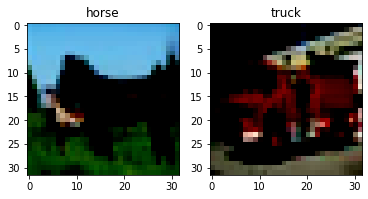

In [5]:
def visualize_image(train_idx: int, test_idx: int):
    """
    Function to visualize the images and labels given an sample number as index in train and test set
    
    Parameters:
    -----------
    train_idx: integer
    test_idx: integer
        
    """
    img1, label1 = trainset[train_idx]
    img2, label2 = testset[test_idx]
    print('Shape of single image: ', img1.shape)
    plt.subplot(121)
    plt.imshow(img1.permute((1, 2, 0)))
    plt.title(CLASSES[label1])
    plt.subplot(122)
    plt.imshow(img2.permute((1, 2, 0)))
    plt.title(CLASSES[label2])
    plt.show()

if VISUALIZE:
    visualize_image(12, 23)
    

                      

In [6]:
if torch.cuda.is_available():
    device_under_use = torch.device("cuda")
else:
    device_under_use = torch.device("cpu")
print(device_under_use)

cpu


In [7]:
# Get PyTorch train and validation samplers
def split(dataset: torch.utils.data.Dataset, 
          train_data_ratio: float = 0.7,
          shuffle: bool = True,
          random_seed: int = 0,
         ) -> typing.Tuple[SubsetRandomSampler, SubsetRandomSampler]:
    """
    Function to split train set into train & valid SubsetRandomSamplers.
    This doesnot return in 2 seperate torch.utils.data.Dataset() classes but returns 2 different Samplers.
    
    Parameters:
    -----------
    dataset: torch.utils.data.Dataset()
        Train set of CIFAR 10
    train_data_ratio: float
        Train data ratio, should be <1.0
    shuffle: bool
        Whether the output samplers will be shuffled or not.
    random_seed: int
        For setting np.random.seed() for shuffling (if shuffle==True)
    
    Return:
    -------
    train_sampler, valid_sampler, test_sampler: Tuple[SubsetRandomSampler, SubsetRandomSampler, SubsetRandomSampler]
        Individual samplers for train, validation and test data.
    """

    num_data = len(dataset)
    indices = list(range(num_data))
    split_train = int(np.floor(train_data_ratio * num_data))

    if shuffle:
        np.random.seed(random_seed)
        np.random.shuffle(indices)

    train_idx, valid_idx= (
        indices[:split_train],
        indices[split_train:],
    )

    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    return train_sampler, valid_sampler

In [8]:
def get_train_valid_test_loader(train_dataset: torch.utils.data.Dataset,
                                test_dataset: torch.utils.data.Dataset,
                                train_batch_size: int = 8,
                                val_batch_size: int = 8,
                                test_batch_size: int = 8,
                                random_seed: int = 0,
                                shuffle: bool = True,
                                num_workers: int = 0,
                                pin_memory: bool = True,
                               ) -> typing.Tuple[torch.utils.data.DataLoader,
                                                 torch.utils.data.DataLoader, 
                                                 torch.utils.data.DataLoader,
                                                ]:
    """
    Parameters:
    -----------
    train_dataset: torch.utils.data.Dataset()
        Train set
    test_dataset: torch.utils.data.Dataset()
        Train set
    batch_size: int
        Batch size for training. The loader provides batch_size number of samples for each training time step.
    random_seed: int
        For setting np.random.seed() for shuffling (if shuffle==True)
    shuffle: bool
        If set true, the data is shuffled before sampling
    num_workers:: int
        How many subprocesses to use for data loading. 0 means the data will be loaded in the main process only.
    pin_memory: bool
        Decided whether data loader should copy the Tensors into CUDA pinned memory.
    
    Return:
    -------
    train_loader, valid_loader, test_loader:
        Tuple[torch.utils.data.DataLoader, torch.utils.data.DataLoader, torch.utils.data.DataLoader]
        DataLoader for each sets of data.
    """

    
    # get train, validation and test samplers
    train_sampler, valid_sampler= split(
        train_dataset,
        train_data_ratio=0.7,
        shuffle=shuffle,
        random_seed=random_seed,
    )
    
    # load dataset
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=train_batch_size,
        sampler=train_sampler,
        num_workers=num_workers,
        pin_memory=pin_memory,
    )

    valid_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=val_batch_size,
        sampler=valid_sampler,
        num_workers=num_workers,
        pin_memory=pin_memory,
    )

    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=test_batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=False,
    )

    return train_loader, valid_loader, test_loader

In [9]:
def accuracy_metric(Y: np.ndarray,
                    predictions: np.ndarray,
                   ) -> float:
    """
    Parameters:
    -----------
    Y: np.ndarray
        True labels in the test set
    predictions: np.ndarray
        Predictions on MNIST test set using the trained 2-layer NN
        
    Return:
    -------
    accuracy: float
        Accuracy metric on the Y and predictions provided to the function 
    
    """
    correct = 0
    for i in range(len(Y)):
        if Y[i] == predictions[i]:
            correct += 1
    accuracy = correct / float(len(Y)) * 100.0
    return accuracy

def metrics(Y: np.ndarray,
            predictions: np.ndarray,
            print_metrics: bool = False) -> typing.Tuple:
    """
    Calculates the accuracy and prints the confusion matrix for the true labels and predictions provided
    Parameters:
    -----------
    Y: np.ndarray
        True labels in the test set
    predictions: np.ndarray
        Predictions on MNIST test set using the trained 2-layer NN
    print_metrics: bool
        Flag to allow printing of the metrics calculated
    
    Return:
    -------
    accuracy: float
        Accuracy for the labels and predictions provided
    df_confusion: pandas dataframe
        Confusion matrix for the labels and predictions provided
        
    """
    accuracy = accuracy_metric(Y, predictions)
    df_confusion = pd.crosstab(Y, predictions, rownames=['Actual'], colnames=['Predicted'], margins=True)
    
    if print_metrics:
        print("Accuracy: ", accuracy)
        print("Confusion matrix: \n", df_confusion)
        
    return accuracy, df_confusion


In [10]:
def validation(valid_loader: torch.utils.data.DataLoader, 
               model: torch.nn,
               criterion,
               regularization_level,
               regularization_rate,
              ) -> typing.Tuple:
    
    """
    Validation module
    
    Parameters:
    -----------
    valid_loader: torch.utils.data.DataLoader
        Validation data loader
    model: torch.nn
        Model
    
    Return:
    -------
    avg_val_loss: float
        Validation loss for 1 full pass of the validation data
        
    avg_val_accuracy: float
        Validation accuracy for 1 full pass of the validation data
    
    """
    
    model.train(False)
    
    valid_len = len(valid_loader.batch_sampler)
    av_loss = 0
    av_accuracy = 0
    y_pred = []
    y_true = []
    
    for images, labels in valid_loader:
    
        images = images.view(-1, 3* 32 * 32).to(device_under_use)
        labels = labels.to(device_under_use)
        
        outputs = model(images)
        
        loss = criterion(outputs, labels)
        weight_norm = get_regularizer(model, regularization_level)
        loss = loss + regularization_rate * weight_norm
        av_loss += loss.detach().item()
        
        _, predicted = torch.max(outputs.data, 1)
        y_pred.extend(predicted.tolist())
        
        labels_list = labels.tolist()
        y_true.extend(labels_list)
        
        accuracy, df_confusion = metrics(np.array(y_true), np.array(y_pred))
        av_accuracy += accuracy
    
    avg_val_loss = av_loss / valid_len
    avg_val_accuracy = av_accuracy / valid_len
    
    return avg_val_loss, avg_val_accuracy
    

In [11]:
def evaluation(test_loader:  torch.utils.data.DataLoader,
               model: torch.nn,
               criterion,
              ) -> typing.Tuple:
    
    """
    Testing module
    
    Parameters:
    -----------
    test_loader:  torch.utils.data.DataLoader
        Validation data loader
    model: torch.nn
        Model
    
    Return:
    -------
    avg_test_loss: float
        Average loss for the test set
    accuracy: float
        Accuracy for the labels and predictions provided
    df_confusion: pandas dataframe
        Confusion matrix for the labels and predictions provided
        
    """
    
    model.eval()
    
    test_len = len(test_loader.batch_sampler)
    print('Size of test data: ', test_len)
    
    test_loss = 0
    confusion_matrix = np.zeros((11, 11))
    accuracy_list = []
    y_pred = []
    y_true = []
    
    for images, labels in test_loader:
    
        images = images.view(-1, 3* 32 * 32).to(device_under_use)
        labels = labels.to(device_under_use)
        
        outputs = model(images)
        
        loss = criterion(outputs, labels)
        test_loss += loss.detach().item()
        
        _, predicted = torch.max(outputs.data, 1)
        y_pred.extend(predicted.tolist())
        
        labels_list = labels.tolist()
        y_true.extend(labels_list)
        
    accuracy, df_confusion = metrics(np.array(y_true), np.array(y_pred), True)
    avg_test_loss = test_loss / test_len
    return avg_test_loss, accuracy, df_confusion

In [12]:
def plot_training_graph(train_data: typing.List, 
                        val_data: typing.List,
                        label: bool):
    
    """
    Visualize the training/validation loss/accuracy of the model
    
    Parameters:
    -----------
    train_data: typing.List
        Train loss/accuracy per epoch
    val_data: typing.List,
        Validation loss/accuracy per epoch
    label: bool
        Flag stating whether loss/accuracy
    
    """
    if label == 'accuracy':
        train_label = 'Training accuracy'
        val_label = 'Validation accuracy'
        x_label = 'Epoch'
        y_label = 'Accuracy'
        title = 'Epoch vs Accuracy'
    else:
        train_label = 'Training loss'
        val_label = 'Validation loss'
        x_label = 'Epoch'
        y_label = 'Loss'
        title = 'Epoch vs Loss'
    fig = plt.figure(figsize=(12,12))
    plt.plot(train_data, c='k', label=train_label)
    plt.plot(val_data, c='m', label=val_label)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend()
    plt.grid()
    plt.show()
    return fig

In [13]:
def get_gradients(named_parameters: typing.Generator) -> typing.List:
    
    """
    Parameters:
    -----------
    named_parameters: typing.Generator 
        model layer names and tensor value
    
    Return:
    -------
    norm_grads: typing.List
        List of gradient norms for all layers in the model named parameters
    
    """
    norm_grads = []
    layers = []
    for name, tensor_value in named_parameters:
        
        if tensor_value.requires_grad:
            layers.append(name)
            norm_grads.append(tensor_value.grad.abs().norm().item())
            
    return norm_grads

In [27]:
def plot_norm_grads(named_parameters: typing.Generator, 
                    norm_grads: typing.List):
    
    """
    Parameters:
    -----------
    named_parameters: typing.Generator 
        model layer names and tensor value
    
    norm_grads: typing.List
        List of gradient norms for all layers in the model named parameters
    
    """
    norm_grads_array = np.array(norm_grads)
    
    plots_per_row = 2
    rows = int(norm_grads_array.shape[1] / plots_per_row) 
    columns = min(norm_grads_array.shape[1], plots_per_row)
    remaining = (norm_grads_array.shape[1] - (rows * columns))
    if remaining:
        rows = rows + 1
    
    if rows > 5:
        fig, axs = plt.subplots(rows, columns, figsize=(35, 12), facecolor='w', edgecolor='k')
    else:
        fig, axs = plt.subplots(rows, columns, figsize=(20, 12), facecolor='w', edgecolor='k')
    fig.suptitle("Layer-wise gradient norm")
    fig.subplots_adjust(left=0.125, bottom=0.2, right=0.9, top=0.9, wspace=0.2, hspace=1.3)
    
    layers = []
    for name, tensor_value in named_parameters:
        if tensor_value.requires_grad:
            layers.append(name)

    axs = axs.flatten()
    for i, ax in enumerate(axs):
        ax.plot(norm_grads_array[:, i])
        ax.set_title(layers[i])
        ax.set_xlabel('Epochs')
        ax.set_ylabel('Gradient norm')
        
    plt.show()
    return fig

In [15]:
def get_optimizer(model: torch.nn.Module,
                  optimizer_class: str = "SGD", 
                  learning_rate: float = 0.01, 
                  weight_decay: float = 0,) -> torch.optim:
    
    """
    Provides an optimizer for training the model depending on the string passed
    Parameters:
    -----------
    model: torch.nn
        Classifier model
    learning_rate: float
        Learning rate for weight update
    optimizer_class: str
        Optimizer used in training
    weight_decay: str
        Weight decay for the parameters during the optimization process
    Return:
    -------
    optimizer: torch.optim
        Optimizer Pytorch
    
    """
    
    if optimizer_class == "SGD":
        return torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    elif optimizer_class == "ADAM":
        return torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    elif optimizer_class == "ADAGRAD":
        return torch.optim.Adagrad(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    elif optimizer_class == "ADADELTA":
        return torch.optim.Adadelta(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    elif optimizer_class == "RMSPROP":
        return torch.optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        
    

In [16]:
def softmax(x: torch.Tensor) -> torch.Tensor:
    
    """
    Parameters:
    -----------
    x: torch.Tensor
        Input tensor to perform softmax
        
    Return:
    -------
    Softmax(x)
    """
    return x - x.exp().sum(-1).log().unsqueeze(-1)

def nl(input_: torch.Tensor, 
       target: torch.Tensor,
      ) -> torch.Tensor: 
    """
    Parameters:
    -----------
    input_: torch.Tensor
        Input tensor for nl: SOFTMAX(PREDICTIONS)
    target: torch.Tensor
        Target tensor for CE: NL(input_, target)
    
    Return: 
    -------
    loss: torch.Tensor
        NL(input_, target)
    """
    return -input_[range(target.shape[0]), target].mean()

def ce_loss(predictions: torch.Tensor, 
            targets: torch.Tensor,
           ) -> torch.Tensor:
    """
    Parameters:
    -----------
    predictions: torch.Tensor
        Input tensor are model predictions
    targets: torch.Tensor
        Ground truth labels
    
    Return: 
    -------
    loss: torch.Tensor
        NL(SOFTMAX(predictions), targets)
    """
    soft_out = softmax(predictions)
    loss = nl(soft_out, targets)
    return loss

def hinge_loss_non_vector(predictions: torch.Tensor,
                          targets: torch.Tensor,
                         ) -> torch.Tensor:
    """
    Parameters:
    -----------
    predictions: torch.Tensor
        Input tensor are model predictions
    targets: torch.Tensor
        Ground truth labels
    
    Return: 
    -------
    loss: torch.Tensor
        mean(sum_j!=y(max(0, s_i - s_j + 1)))
    """
    loss_per_image = []
    for i in zip(predictions, targets):
        sum_ = [max(0, i[0][j] - i[0][i[1].item()].item() + 1) for j in range(len(i[0])) if j != i[1].item()]  
        loss_per_image.append(sum(sum_))
    loss = sum(loss_per_image) / len(loss_per_image)
    return loss

def hinge_loss_vectorized(predictions: torch.Tensor, 
                          targets: torch.Tensor,
                         ) -> torch.Tensor:
    """
    Parameters:
    -----------
    predictions: torch.Tensor
        Input tensor are model predictions
    targets: torch.Tensor
        Ground truth labels
    
    Return: 
    -------
    loss: torch.Tensor
        mean(sum_j!=y(max(0, s_i - s_j + 1)))
    """
    loss = 0
    for pred, y in zip(predictions, targets): 
        margin = torch.relu(pred - pred[y] + 1)
        margin[y] = 0
        loss_i = torch.sum(margin)
        loss = loss + (loss_i)
    mean_loss = loss / len(predictions)
    return mean_loss

def get_criterion(criterion_class: str):
    
    """
    Parameters:
    -----------
    criterion_class: str 
        Criterion required for training as string
        
    Return:
    -------
    Criterion: Union[torch.nn, typing.Callable]
        Loss function for training
    
    """
    
    if criterion_class == "PyTorch Cross-Entropy":
        return nn.CrossEntropyLoss().to(device_under_use)
    
    elif criterion_class == "Manual Cross-Entropy":
        return ce_loss
    
    elif criterion_class == "Manual SVM-Hinge":
        return hinge_loss_vectorized
    
    

In [17]:
def test_hinge_implementation():
    """
    A simple test case for hinge loss
    """
    pred = torch.FloatTensor([[3.2, 5.1, -1.7], [1.3, 4.9, 2.0], [2.2, 2.5, -3.1], [3.2, 5.1, -1.7]])
    y = torch.LongTensor([0, 1, 2, 0])
    assert hinge_loss_vectorized(pred, y) == hinge_loss_non_vector(pred, y)
test_hinge_implementation()

In [18]:
def get_regularizer(model: torch.nn, 
                    regularization_level: str,
                   ) -> torch.Tensor:
    """
    Parameters:
    -----------
    model: torch.nn
        Classifier model
    regularization_level: str
        String for L1 or L2 regularization
        
    Return:
    -------
    l_reg: torch.Tensor
        Either L1 or L2 regularized value for the model parameters provided
    
    """
    if regularization_level == "L1":
        norm_ = 1
    elif regularization_level == "L2":
        norm_ = 2
    l_reg = None
    for W in model.parameters():
        if l_reg is None:
            l_reg = W.norm(norm_)
        else:
            l_reg = l_reg + W.norm(norm_)
    return l_reg

In [19]:
def trainer(train_loader: torch.utils.data.DataLoader,
            valid_loader: torch.utils.data.DataLoader,
            model: torch.nn,
            num_epochs: int,
            learning_rate: float,
            patience: int,
            optimizer: torch.optim,
            criterion,
            writer,
            early_stopping: bool = True,
            regularization_level: str = "L2",
            regularization_rate: float = 0.001,
            plot_gradients: bool = True,
            additional_scalar_identifier: str = '',
           ) -> typing.Tuple:
    
    """
    Parameters:
    -----------
    train_loader: torch.utils.data.DataLoader
        Train data loader
    valid_loader: torch.utils.data.DataLoader
        Validation data loader
    model: torch.nn
        Classifier model
    num_epochs: int
        Maximum epoch limit
    learning_rate: float
        Learning rate for weight update
    patience: int
        Patience to trigger early stopping    
    plot_gradients: bool
        Flag to plot all the layer-wise weight gradients
    optimizer_class: str
        Optimizer used in training
    regularization_level: str
        String for L1 or L2 regularization
    regularization_rate: float
        Lambda value for regularization
    criterion_class: str
        Loss function used in the classifer training
    early_stopping: bool
        Whether early stopping is activated or not
    writer: tensorboard.summarywriter
        Summary writer for tensorboard
    additional_scalar_identifier: str
        String to differentiate different experimental parameters in the tensorboard graph names
        
    Return:
    -------
    best_model: torch.nn
        Best model from training depending on the validation loss
    train_costs_per_epoch: List
        List containing loss on training data for each epoch
    val_costs_per_epoch: List
        List containing loss on validation data for each epoch
    train_accuracy_per_epoch: List
        List containing accuracy on training data for each epoch
    val_accuracy_per_epoch: List
        List containing loss on validation data for each epoch
    fig_gradients: matplotlib.pyplot
        Gradients norm across model parameters
    Epoch: int 
        Num epochs ran
    
    """
    
    # num_epochs = int(n_iters/(len(train_loader.batch_sampler)))
    patience_count = patience
    
    
    best_validation_loss = np.inf
    train_costs_per_epoch = []
    val_costs_per_epoch = []
    best_model = model
    norm_grads = []
    train_accuracy_per_epoch = []
    val_accuracy_per_epoch = []
    
    for epoch in range(num_epochs):

        running_train_loss = []
        running_norm_grads = []
        running_train_accuracy = []
        y_pred = []
        y_true = []
        
        model.train(True)

        for images, labels in train_loader:

            images = images.view(-1, 3* 32 * 32).to(device_under_use)
            labels = labels.to(device_under_use)

            optimizer.zero_grad()

            outputs = model(images)

            loss = criterion(outputs, labels)
            weight_norm = get_regularizer(model, regularization_level)
            loss = loss + regularization_rate * weight_norm
            running_train_loss.append(loss.detach().item())
            loss.backward()
            running_norm_grads.append(get_gradients(model.named_parameters()))
            optimizer.step()
            
            _, predicted = torch.max(outputs.data, 1)
            y_pred.extend(predicted.tolist())
        
            labels_list = labels.tolist()
            y_true.extend(labels_list)
        
            accuracy, df_confusion = metrics(np.array(y_true), np.array(y_pred))
            running_train_accuracy.append(accuracy)

        avg_train_loss = sum(running_train_loss) / len(running_train_loss)
        train_costs_per_epoch.append(avg_train_loss)

        avg_val_loss, avg_val_accuracy = validation(valid_loader, 
                                                    model, 
                                                    criterion, 
                                                    regularization_level=regularization_level, 
                                                    regularization_rate=regularization_rate,
                                                   )
        val_costs_per_epoch.append(avg_val_loss)
        val_accuracy_per_epoch.append(avg_val_accuracy)
        
        norm_grads_avg = list(np.mean(np.array(running_norm_grads), axis=0))
        norm_grads.append(norm_grads_avg)
        
        avg_train_accuracy = sum(running_train_accuracy) / len(running_train_accuracy)
        train_accuracy_per_epoch.append(avg_train_accuracy)
    
        # Early stopping: Waits up to the 'patience' number of epochs for a better model
        # If a better model is not found for the 'patience' number of epochs then training stops
        # To avoid overfitting of the model to the train set

        writer.add_scalar("training/average_train_loss" + additional_scalar_identifier, avg_train_loss, epoch + 1)
        writer.add_scalar("validation/average_valid_loss" + additional_scalar_identifier, avg_val_loss, epoch + 1)
        writer.add_scalar("training/average_train_accuracy" + additional_scalar_identifier, avg_train_accuracy, epoch + 1)
        writer.add_scalar("validation/average_valid_accuracy" + additional_scalar_identifier, avg_val_accuracy, epoch + 1)
        
        if early_stopping:
            if avg_val_loss < best_validation_loss:
                best_validation_loss = avg_val_loss
                best_model = model
                patience_count = patience
                print("Better model found: Epoch: %i -- Train loss: %f -- Validation loss: %f"%(epoch + 1, avg_train_loss, avg_val_loss))
            else:
                patience_count = patience_count - 1
                print("No better model found: Epoch: %i -- Train loss: %f -- Validation loss: %f"%(epoch + 1, avg_train_loss, avg_val_loss))

            if patience_count == 0:
                print("Early stopping triggered: Epoch: %i -- Train loss: %f -- Validation loss: %f" %(epoch + 1, avg_train_loss, avg_val_loss))
                break 
        else:
            if avg_val_loss < best_validation_loss:
                best_validation_loss = avg_val_loss
                best_model = model
                print("Better model found: Epoch: %i -- Train loss: %f -- Validation loss: %f"%(epoch + 1, avg_train_loss, avg_val_loss))
            else:
                print("No better model found: Epoch: %i -- Train loss: %f -- Validation loss: %f"%(epoch + 1, avg_train_loss, avg_val_loss))
            
            
    fig_gradients = None
    if plot_gradients:
        fig_gradients = plot_norm_grads(model.named_parameters(), norm_grads)
        
    return best_model, train_costs_per_epoch, val_costs_per_epoch, train_accuracy_per_epoch, val_accuracy_per_epoch, fig_gradients, epoch + 1

In [20]:
def get_activation(activation_function: str):
    
    """
    Provides an activation function to develop the model depending on the string passed
    
    Parameters:
    -----------
    activation_function: str
        Activation function as a string value
    
    Return:
    -------
    activation: torch.nn
        Activation function used in all the layers of the model (except the final layer)
    """
    if activation_function == "RELU":
        activation = nn.ReLU()
    elif activation_function == "SIGMOID":
        activation = nn.Sigmoid()
    elif activation_function == "SOFTMAX":
        activation = nn.Softmax(dim=1)
    elif activation_function == "TANH":
        activation = nn.Tanh()   
        
    return activation
    

In [21]:
class Net(nn.Module):
    def __init__(self, input_dim, 
                 output_dim, 
                 hidden_units=300, 
                 activation_function="SIGMOID",
                 num_layers=2,
                 ):
        super(Net, self).__init__()
        
        self.num_layers = num_layers
        intermediate_units = 100
        activation = get_activation(activation_function)
          

        if num_layers >= 3:
            all_layers = []
            for i in range(num_layers):
                if i == 0:
                    all_layers.extend([nn.Linear(input_dim, hidden_units), activation, nn.Dropout(0.2),])
                elif i == 1:
                    all_layers.extend([nn.Linear(hidden_units, intermediate_units), activation, nn.Dropout(0.2)])
                elif i == num_layers - 1:
                    all_layers.extend([nn.Linear(intermediate_units, output_dim)])
                elif i > 1 and i < num_layers - 1:
                    all_layers.extend([nn.Linear(intermediate_units, intermediate_units), activation, nn.Dropout(0.2)])               

            self.all_layers = nn.ModuleList(all_layers)
            
        else:
            self.all_layers = nn.ModuleList([nn.Linear(input_dim, hidden_units), 
                                            nn.ReLU(),
                                            nn.Dropout(0.2),
                                            nn.Linear(hidden_units, output_dim)])
            
    def forward(self, x):
        out = x
        for i in range(len(self.all_layers)):
            out = self.all_layers[i](out)
        return out

def check_model():
    input_dim = 3 * 32 *32
    output_dim = 10
    num_layers=4
    model = Net(input_dim=input_dim, 
                output_dim=output_dim,
                num_layers=num_layers).to(device_under_use)
    summary(
        model,
        input_size=(3*32*32,),
        batch_size=32,
        device=device_under_use.type,
    )
    
if CHECK_MODEL:
    check_model()
    

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [32, 300]         921,900
           Sigmoid-2                  [32, 300]               0
           Dropout-3                  [32, 300]               0
            Linear-4                  [32, 100]          30,100
           Sigmoid-5                  [32, 100]               0
           Dropout-6                  [32, 100]               0
            Linear-7                  [32, 100]          10,100
           Sigmoid-8                  [32, 100]               0
           Dropout-9                  [32, 100]               0
           Linear-10                   [32, 10]           1,010
Total params: 963,110
Trainable params: 963,110
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.38
Forward/backward pass size (MB): 0.37
Params size (MB): 3.67
Estimated T

In [22]:
def CIFAR10_classifier(experiment_name: str, 
                       learning_rate: float,
                       train_batch_size: int,
                       patience: int,
                       activation_function: str,
                       num_epochs: int,
                       hidden_units: int,
                       num_layers: int,
                       optimizer_class: str, 
                       regularization_level: str = "L2",
                       weight_decay: float = 0.0,
                       criterion_class: str = "PyTorch Cross-Entropy",
                       early_stopping: bool = True,
                       close_writer: bool = False,
                       additional_scalar_identifier: str = '_',
                       plot_gradients=True,
                      ) -> typing.Tuple:

                          
    """
    Function performing the classification on CIFAR10
    
    Parameters:
    -----------
    learning_rate: float
        Learning rate for weight update
    train_batch_size: int
        Batch size of train loader
    patience: int
        Patience to trigger early stopping   
    activation_function: str
        Activation function
    num_epochs: int
        Maximum epoch limit
    hidden_units: int
        Number of hidden units in the hidden layer
    num_layers: int
        Number of hidden layers in the NN
    optimizer_class: str
        Optimizer used in training
    regularization_level: str
        String for L1 or L2 regularization
    weight_decay: float
        Weight decay value for regulariation
    criterion_class: str
        Loss function used in the classifer training
    early_stopping: bool
        Whether early stopping is activated or not
    close_writer: bool
        Flag to close the tensorboard summary writer
    additional_scalar_identifier: str
        String to differentiate different experimental parameters in the tensorboard graph names
    plot_gradients: bool
        Flag to plot the gradient norm
        
    Return:
    -------
    best_model: torch.nn
        Best model from training depending on the validation loss
    accuracy: float
        Accuracy for the labels and predictions provided
    writer: tensorboard.summarywriter
        Summary writer for tensorboard
    
    """
    
    # Hyperparameters
    learning_rate = learning_rate
    train_batch_size = train_batch_size
    patience = patience
    activation_function = activation_function
    num_epochs = num_epochs
    hidden_units = hidden_units
    num_layers = num_layers
    
    # Fixed parameters
    val_batch_size = 100
    test_batch_size = 8
    input_dim = 3 * 32 * 32
    output_dim = 10
    
    print("\n")
    print("##### Statistics of the run #####")
    print("Learning rate: ", learning_rate)
    print("Batch size for training: ", train_batch_size)
    print("Patience for early stopping: ", patience)
    print("Activation function: ", activation_function)
    print("Num epochs: ", num_epochs)
    print("Num hidden units: ", hidden_units)
    print("Num layers: ", num_layers)
    print("Optimizer class: ", optimizer_class)
    print("Regularizer level: ", regularization_level)
    print("Weight decay: ", weight_decay)
    print("Criterion: ", criterion_class)
    
    train_loader, valid_loader, test_loader = get_train_valid_test_loader(train_dataset=trainset,
                                                                          test_dataset=testset,
                                                                          train_batch_size=train_batch_size,
                                                                          val_batch_size=val_batch_size,
                                                                          test_batch_size=test_batch_size,
                                                                          random_seed=0,
                                                                          shuffle=True,
                                                                          num_workers=0,
                                                                          pin_memory=True,
                                                                         )
    print("Number of train batches: ", len(train_loader.batch_sampler))
    print("Number of validation batches: ", len(valid_loader.batch_sampler))
    print("Number of test batches: ", len(test_loader.batch_sampler))
   
    model = Net(input_dim, 
                output_dim, 
                hidden_units, 
                activation_function,
                num_layers).to(device_under_use).to(device_under_use)
    print("Model summary:")
    summary(
        model,
        input_size=(input_dim,),
        batch_size=train_loader.batch_size,
        device=device_under_use.type,
    )
    
    writer = SummaryWriter("runs/" + experiment_name)
    writer.add_graph(model, torch.randn((input_dim,)))

    optimizer = get_optimizer(model=model, 
                              optimizer_class=optimizer_class, 
                              learning_rate=learning_rate, 
                              weight_decay=weight_decay,
                             )
    
    criterion = get_criterion(criterion_class)
    print("\n") 
    print("##### Training module #####")
    best_model, train_costs_per_epoch, val_costs_per_epoch, \
    train_accuracy_per_epoch, val_accuracy_per_epoch, fig_gradients, final_epoch = trainer(train_loader=train_loader,
                                                               valid_loader=valid_loader,
                                                               model=model,
                                                               num_epochs=num_epochs,
                                                               learning_rate=learning_rate,
                                                               patience=patience,
                                                               optimizer=optimizer,
                                                               criterion=criterion,
                                                               regularization_level=regularization_level,
                                                               writer=writer,
                                                               early_stopping=early_stopping,
                                                               additional_scalar_identifier=additional_scalar_identifier,
                                                               plot_gradients=plot_gradients,
                                                               )
    fig_costs = plot_training_graph(train_costs_per_epoch, val_costs_per_epoch, 'loss')
    fig_accuracy = plot_training_graph(train_accuracy_per_epoch, val_accuracy_per_epoch, 'accuracy')
    print("\n")
    print("##### Evaluation module #####")
    avg_test_loss, accuracy, df_confusion = evaluation(test_loader, best_model, criterion)
    print("\n")
    if plot_gradients:
        plot_to_tensorboard(writer, "Gradients" + additional_scalar_identifier, fig_gradients, 0)
    plot_to_tensorboard(writer, "Learning curve: loss" + additional_scalar_identifier, fig_costs, 0)
    plot_to_tensorboard(writer, "Learning curve: accuracy" + additional_scalar_identifier, fig_accuracy, 0)
    
    if close_writer:
        writer.close()
    return best_model, accuracy, writer


In [23]:
def plot_to_tensorboard(writer, tag, fig, step):
    """
    Takes a matplotlib figure handle and converts it using
    canvas and string-casts to a numpy array that can be
    visualized in TensorBoard using the add_image function

    Parameters:
        writer (tensorboard.SummaryWriter): TensorBoard SummaryWriter instance.
        fig (matplotlib.pyplot.fig): Matplotlib figure handle.
        step (int): counter usually specifying steps/epochs/time.
    """

    # Draw figure on canvas
    fig.canvas.draw()

    # Convert the figure to numpy array, read the pixel values and reshape the array
    img = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
    img = img.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    
    # Normalize into 0-1 range for TensorBoard(X). Swap axes for newer versions where API expects colors in first dim
    img = img / 255.0
    img = np.swapaxes(img, 0, 2)
    img = np.swapaxes(img, 1, 2)
    
    # Add figure in numpy "image" to TensorBoard writer
    writer.add_image(tag, img, 0)
    plt.close(fig)

In [24]:
# Fixing few parameter as constants for usage across the entire notebook for experiments like:
# 1. layers vs epochs
# 2. Optimizer analysis
# 3. Activation function analysis
LEARNING_RATE = 0.01
TRAIN_BATCH_SIZE = 100
PATIENCE = 3
ACTIVATION_FUNCTION = "RELU"
NUM_EPOCHS = 10
HIDDEN_UNITS = 500
NUM_LAYERS = 5
OPTIMIZER_CLASS = "SGD"
WEIGHT_DECAY = 0
REGULARIZATION_LEVEL = "L2"
CRITERION_CLASS = "Manual Cross-Entropy"
EARLY_STOPPING = False



##### Statistics of the run #####
Learning rate:  0.01
Batch size for training:  100
Patience for early stopping:  3
Activation function:  RELU
Num epochs:  10
Num hidden units:  500
Num layers:  1
Optimizer class:  SGD
Regularizer level:  L2
Weight decay:  0
Criterion:  Manual Cross-Entropy
Number of train batches:  350
Number of validation batches:  150
Number of test batches:  1250
Model summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [100, 500]       1,536,500
              ReLU-2                 [100, 500]               0
           Dropout-3                 [100, 500]               0
            Linear-4                  [100, 10]           5,010
Total params: 1,541,510
Trainable params: 1,541,510
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 1.17
Forward/backward pass size (MB): 1.15
Params si

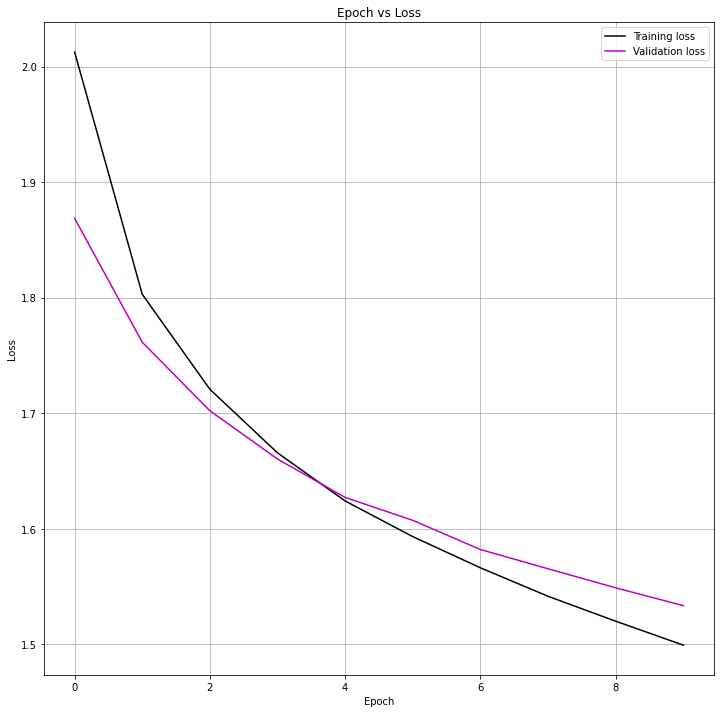

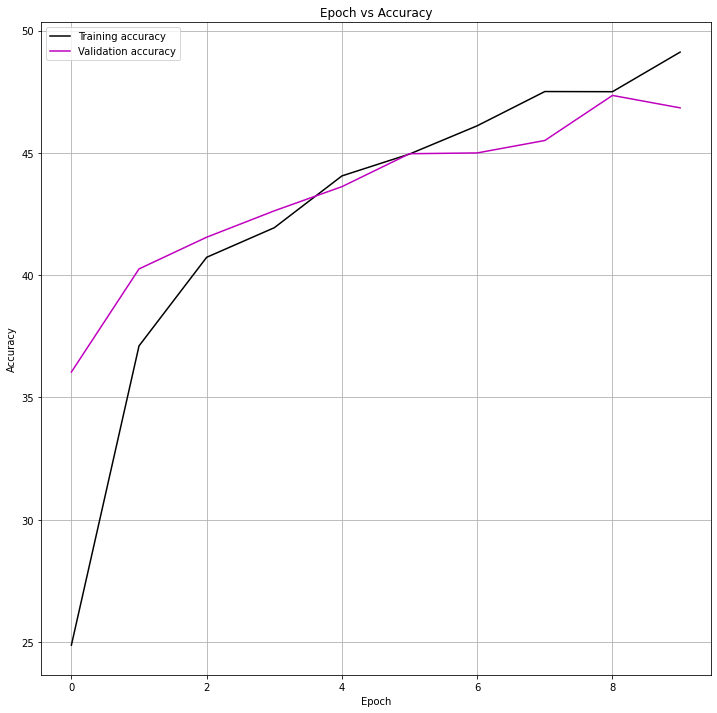



##### Evaluation module #####
Size of test data:  1250
Accuracy:  47.73
Confusion matrix: 
 Predicted    0     1    2    3    4    5     6     7     8     9    All
Actual                                                                 
0          509    43   54   20   24   13    29    48   195    65   1000
1           27   589   26   25   13   11    35    37    82   155   1000
2           85    30  317   94  117   63   148    91    33    22   1000
3           38    28   83  300   49  155   154    82    38    73   1000
4           47    23  126   57  346   48   170   122    30    31   1000
5           19    22   89  186   59  346    99   103    42    35   1000
6           12    22   68   85   89   47   585    41    17    34   1000
7           31    25   47   57   70   61    44   557    30    78   1000
8           79    84   16   20   15   22     8    20   657    79   1000
9           38   174   15   34   12   12    35    51    62   567   1000
All        885  1040  841  878  794  778  

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


Model summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [100, 500]       1,536,500
              ReLU-2                 [100, 500]               0
           Dropout-3                 [100, 500]               0
            Linear-4                 [100, 100]          50,100
              ReLU-5                 [100, 100]               0
           Dropout-6                 [100, 100]               0
            Linear-7                  [100, 10]           1,010
Total params: 1,587,610
Trainable params: 1,587,610
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 1.17
Forward/backward pass size (MB): 1.38
Params size (MB): 6.06
Estimated Total Size (MB): 8.61
----------------------------------------------------------------


##### Training module #####
Better model found: Epoch: 1 -- Train loss: 2.210219 -- V

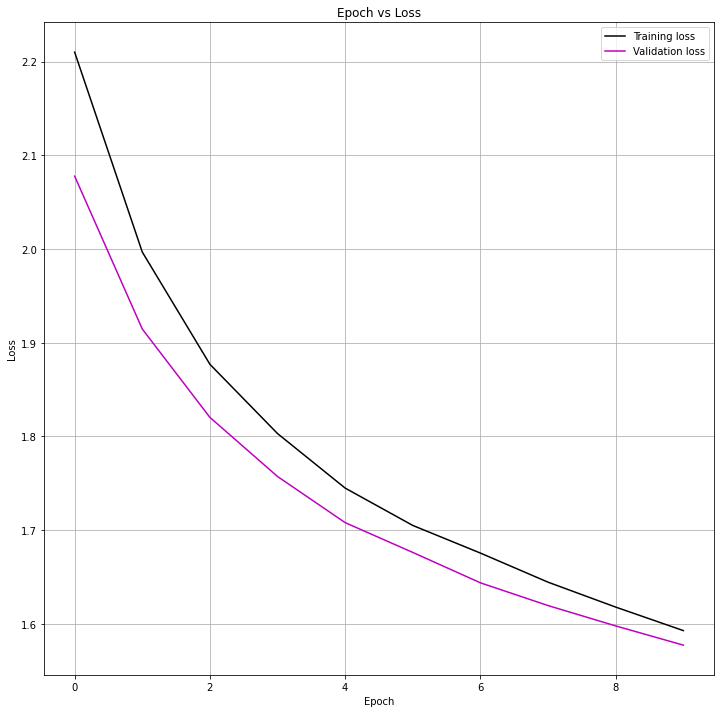

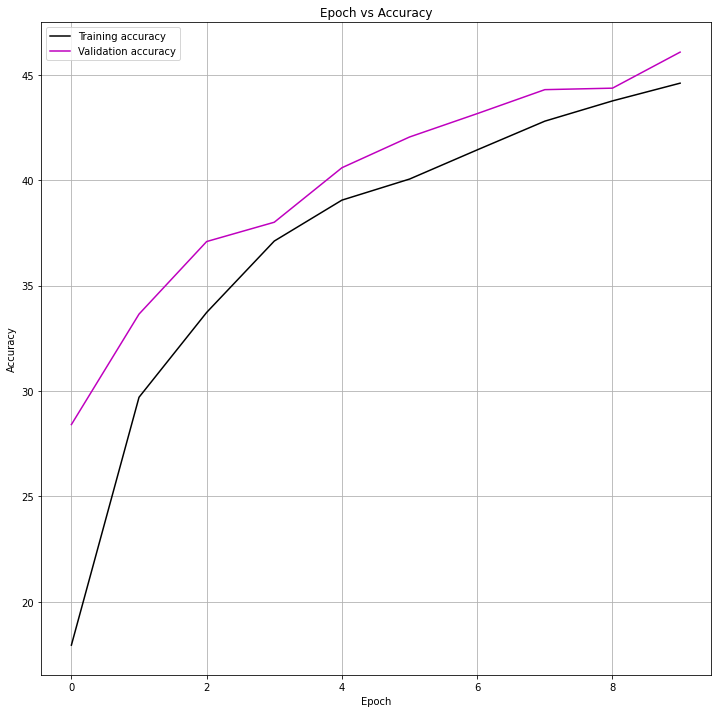



##### Evaluation module #####
Size of test data:  1250
Accuracy:  46.379999999999995
Confusion matrix: 
 Predicted    0     1    2    3    4    5     6     7     8     9    All
Actual                                                                 
0          517    48   59   19   15   14    31    47   195    55   1000
1           41   594   16   32   10   16    30    31    81   149   1000
2           90    32  322   96   94   66   164    88    28    20   1000
3           35    40   85  317   30  168   152    79    32    62   1000
4           52    31  178   58  291   56   164   121    26    23   1000
5           24    26  108  199   45  336   110    94    39    19   1000
6           11    33   84   94   72   60   573    34     9    30   1000
7           40    32   50   61   72   69    51   535    20    70   1000
8           93    88   17   25   14   33     5    14   632    79   1000
9           45   205   12   31    9   13    31    54    79   521   1000
All        948  1129  931  93

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


For 3 layers, the accuracy in test set is 46.379999999999995


##### Statistics of the run #####
Learning rate:  0.01
Batch size for training:  100
Patience for early stopping:  3
Activation function:  RELU
Num epochs:  10
Num hidden units:  500
Num layers:  5
Optimizer class:  SGD
Regularizer level:  L2
Weight decay:  0
Criterion:  Manual Cross-Entropy
Number of train batches:  350
Number of validation batches:  150
Number of test batches:  1250
Model summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [100, 500]       1,536,500
              ReLU-2                 [100, 500]               0
           Dropout-3                 [100, 500]               0
            Linear-4                 [100, 100]          50,100
              ReLU-5                 [100, 100]               0
           Dropout-6                 [100, 100]               0
            Linear-7 

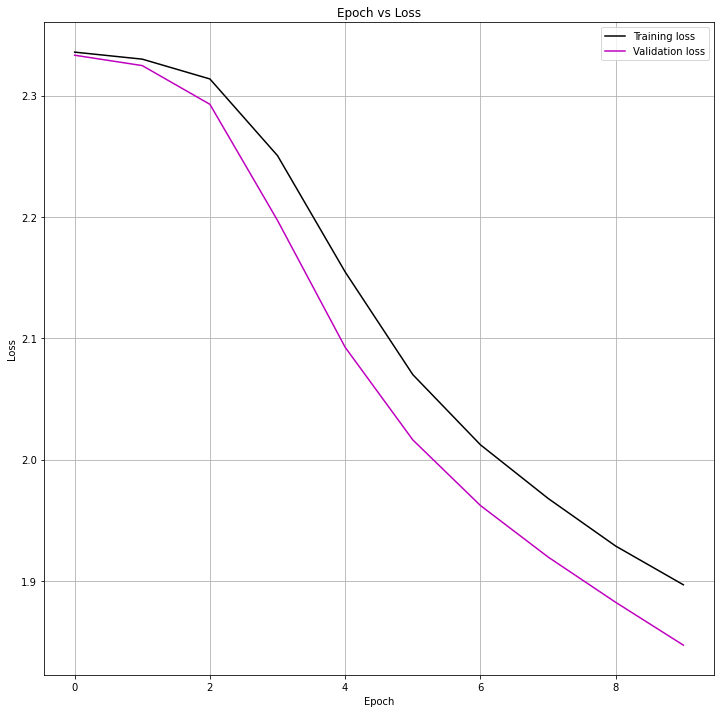

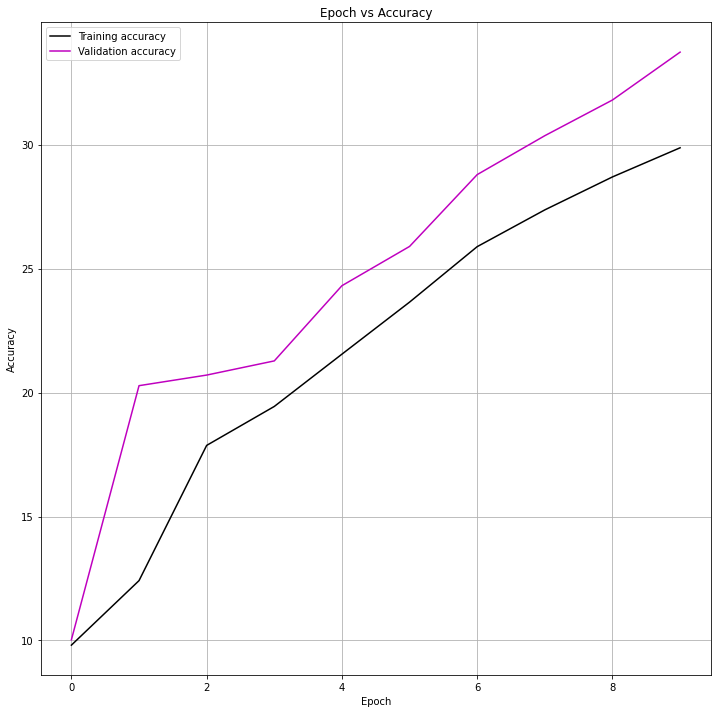



##### Evaluation module #####
Size of test data:  1250
Accuracy:  34.37
Confusion matrix: 
 Predicted     0    1    2   3    4     5     6     7     8     9    All
Actual                                                                 
0           498   47   53   5    8    31    30    51   230    47   1000
1            39  352    6   2    1    38    47    54   153   308   1000
2           148   38  145   7   74   143   305    97    22    21   1000
3            59   57   75  10   15   329   204   175    19    57   1000
4            62   31   78   1  105   120   431   107    31    34   1000
5            55   27   73   6   29   447   182   123    35    23   1000
6            11   39   48   2   34   157   541   143     1    24   1000
7            60   71   66   6   59   134   196   299    30    79   1000
8           211   75    8   0    1    61     7    23   529    85   1000
9            37  145    9   2    0    16    31    85   164   511   1000
All        1180  882  561  41  326  1476  

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


Model summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [100, 500]       1,536,500
              ReLU-2                 [100, 500]               0
           Dropout-3                 [100, 500]               0
            Linear-4                 [100, 100]          50,100
              ReLU-5                 [100, 100]               0
           Dropout-6                 [100, 100]               0
            Linear-7                 [100, 100]          10,100
              ReLU-8                 [100, 100]               0
           Dropout-9                 [100, 100]               0
           Linear-10                 [100, 100]          10,100
             ReLU-11                 [100, 100]               0
          Dropout-12                 [100, 100]               0
           Linear-13                 [100, 100]          10,100
             ReLU-14    

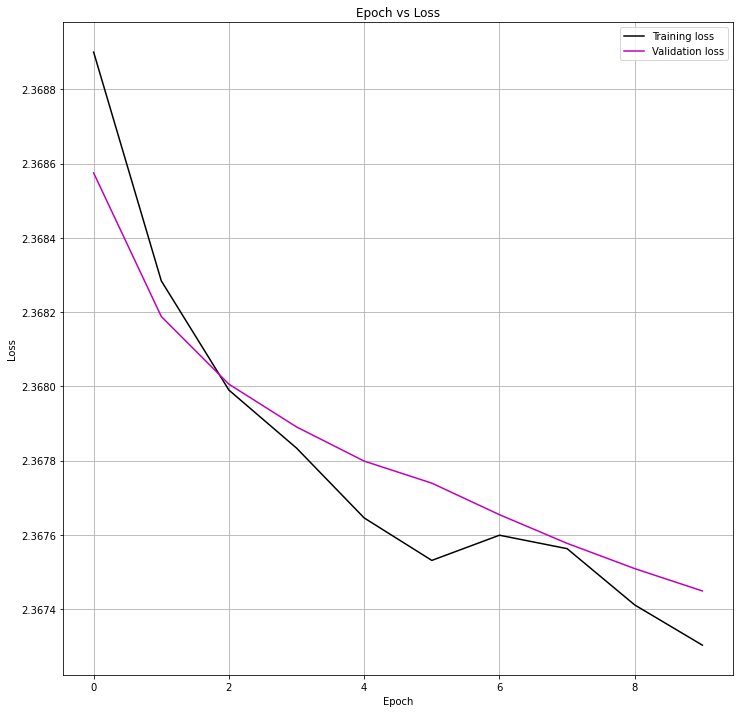

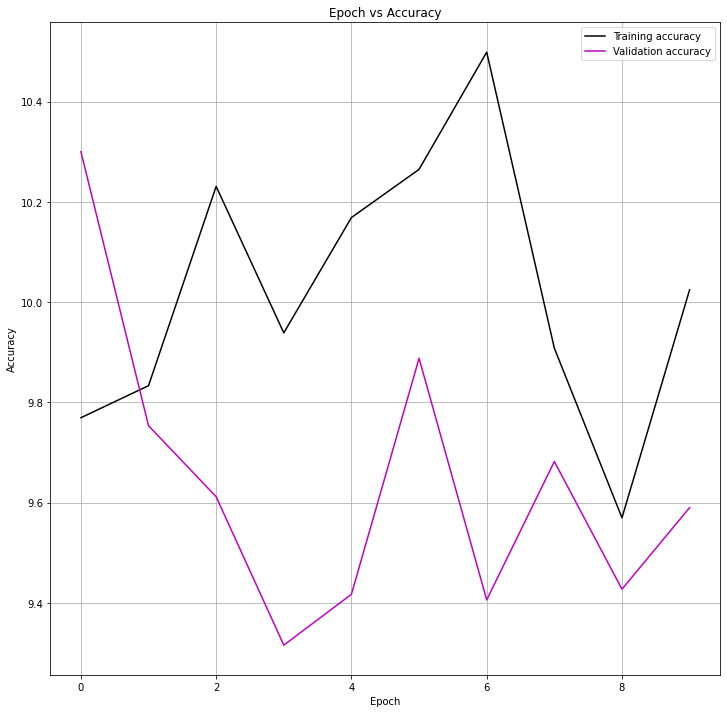



##### Evaluation module #####
Size of test data:  1250
Accuracy:  10.0
Confusion matrix: 
 Predicted      9    All
Actual                 
0           1000   1000
1           1000   1000
2           1000   1000
3           1000   1000
4           1000   1000
5           1000   1000
6           1000   1000
7           1000   1000
8           1000   1000
9           1000   1000
All        10000  10000


For 10 layers, the accuracy in test set is 10.0


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead




##### Statistics of the run #####
Learning rate:  0.01
Batch size for training:  100
Patience for early stopping:  3
Activation function:  RELU
Num epochs:  10
Num hidden units:  500
Num layers:  20
Optimizer class:  SGD
Regularizer level:  L2
Weight decay:  0
Criterion:  Manual Cross-Entropy
Number of train batches:  350
Number of validation batches:  150
Number of test batches:  1250
Model summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [100, 500]       1,536,500
              ReLU-2                 [100, 500]               0
           Dropout-3                 [100, 500]               0
            Linear-4                 [100, 100]          50,100
              ReLU-5                 [100, 100]               0
           Dropout-6                 [100, 100]               0
            Linear-7                 [100, 100]          10,100
              ReL

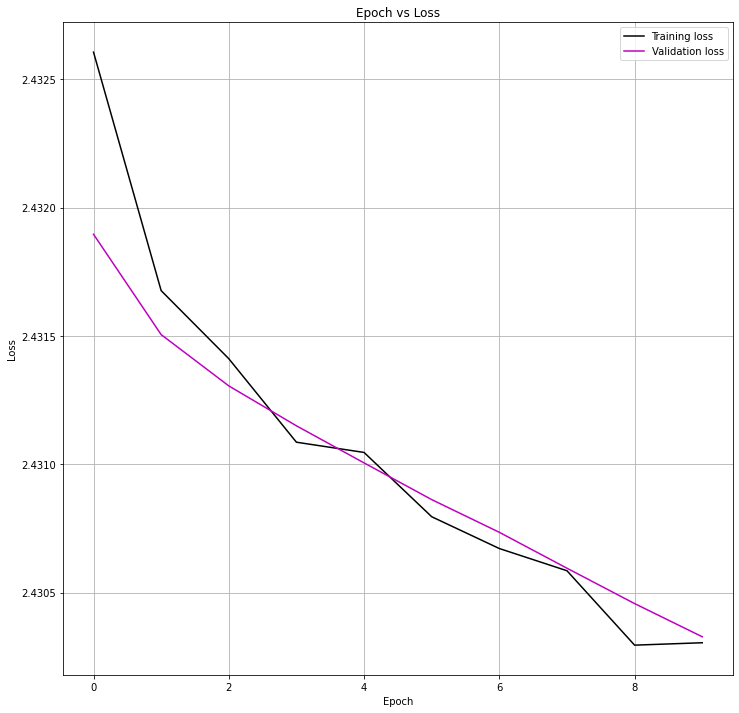

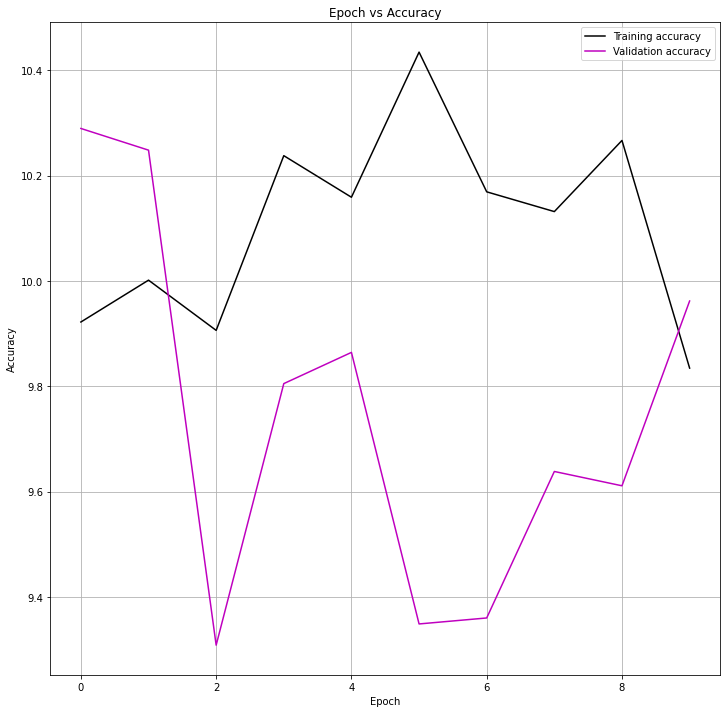



##### Evaluation module #####
Size of test data:  1250
Accuracy:  10.0
Confusion matrix: 
 Predicted      9    All
Actual                 
0           1000   1000
1           1000   1000
2           1000   1000
3           1000   1000
4           1000   1000
5           1000   1000
6           1000   1000
7           1000   1000
8           1000   1000
9           1000   1000
All        10000  10000




/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


For 20 layers, the accuracy in test set is 10.0


##### Statistics of the run #####
Learning rate:  0.01
Batch size for training:  100
Patience for early stopping:  3
Activation function:  RELU
Num epochs:  10
Num hidden units:  500
Num layers:  30
Optimizer class:  SGD
Regularizer level:  L2
Weight decay:  0
Criterion:  Manual Cross-Entropy
Number of train batches:  350
Number of validation batches:  150
Number of test batches:  1250
Model summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [100, 500]       1,536,500
              ReLU-2                 [100, 500]               0
           Dropout-3                 [100, 500]               0
            Linear-4                 [100, 100]          50,100
              ReLU-5                 [100, 100]               0
           Dropout-6                 [100, 100]               0
            Linear-7             

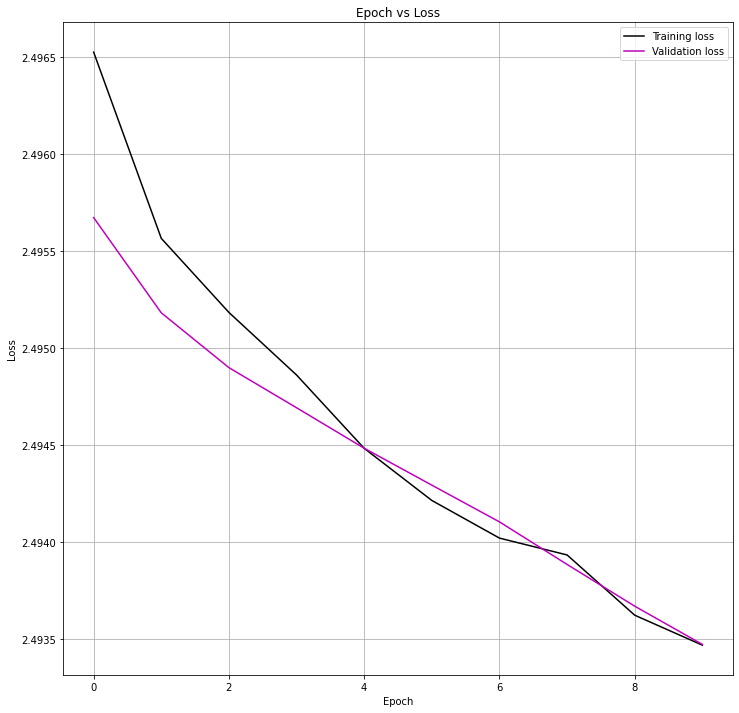

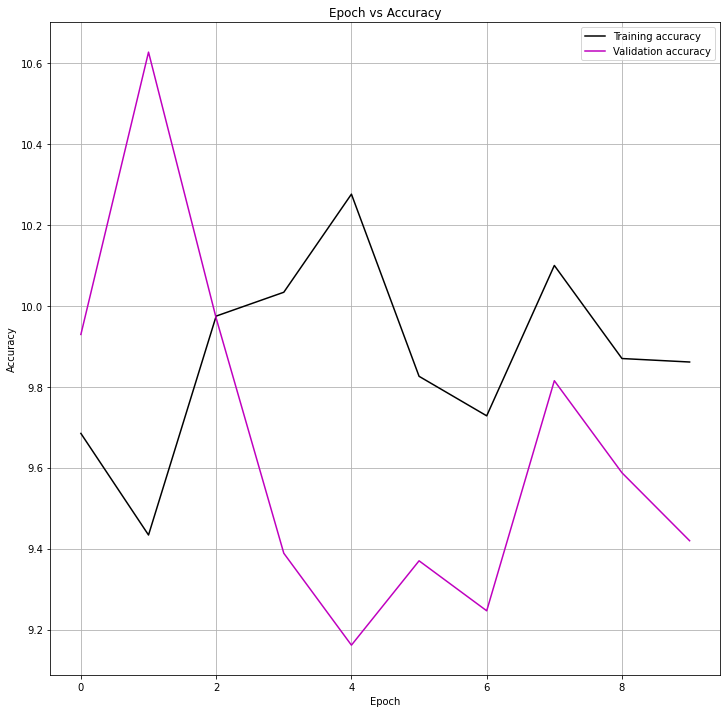



##### Evaluation module #####
Size of test data:  1250
Accuracy:  10.0
Confusion matrix: 
 Predicted      9    All
Actual                 
0           1000   1000
1           1000   1000
2           1000   1000
3           1000   1000
4           1000   1000
5           1000   1000
6           1000   1000
7           1000   1000
8           1000   1000
9           1000   1000
All        10000  10000


For 30 layers, the accuracy in test set is 10.0


##### Statistics of the run #####
Learning rate:  0.01
Batch size for training:  100
Patience for early stopping:  3
Activation function:  RELU
Num epochs:  10
Num hidden units:  500
Num layers:  40
Optimizer class:  SGD
Regularizer level:  L2
Weight decay:  0
Criterion:  Manual Cross-Entropy
Number of train batches: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


 350
Number of validation batches:  150
Number of test batches:  1250
Model summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [100, 500]       1,536,500
              ReLU-2                 [100, 500]               0
           Dropout-3                 [100, 500]               0
            Linear-4                 [100, 100]          50,100
              ReLU-5                 [100, 100]               0
           Dropout-6                 [100, 100]               0
            Linear-7                 [100, 100]          10,100
              ReLU-8                 [100, 100]               0
           Dropout-9                 [100, 100]               0
           Linear-10                 [100, 100]          10,100
             ReLU-11                 [100, 100]               0
          Dropout-12                 [100, 100]               0
           Linear-



##### Training module #####
Better model found: Epoch: 1 -- Train loss: 2.560392 -- Validation loss: 2.559255
Better model found: Epoch: 2 -- Train loss: 2.559064 -- Validation loss: 2.558447
Better model found: Epoch: 3 -- Train loss: 2.558114 -- Validation loss: 2.557994
Better model found: Epoch: 4 -- Train loss: 2.557835 -- Validation loss: 2.557676
Better model found: Epoch: 5 -- Train loss: 2.557388 -- Validation loss: 2.557374
Better model found: Epoch: 6 -- Train loss: 2.557109 -- Validation loss: 2.557102
Better model found: Epoch: 7 -- Train loss: 2.556795 -- Validation loss: 2.556822
Better model found: Epoch: 8 -- Train loss: 2.556644 -- Validation loss: 2.556542
Better model found: Epoch: 9 -- Train loss: 2.556260 -- Validation loss: 2.556260
Better model found: Epoch: 10 -- Train loss: 2.555985 -- Validation loss: 2.555985


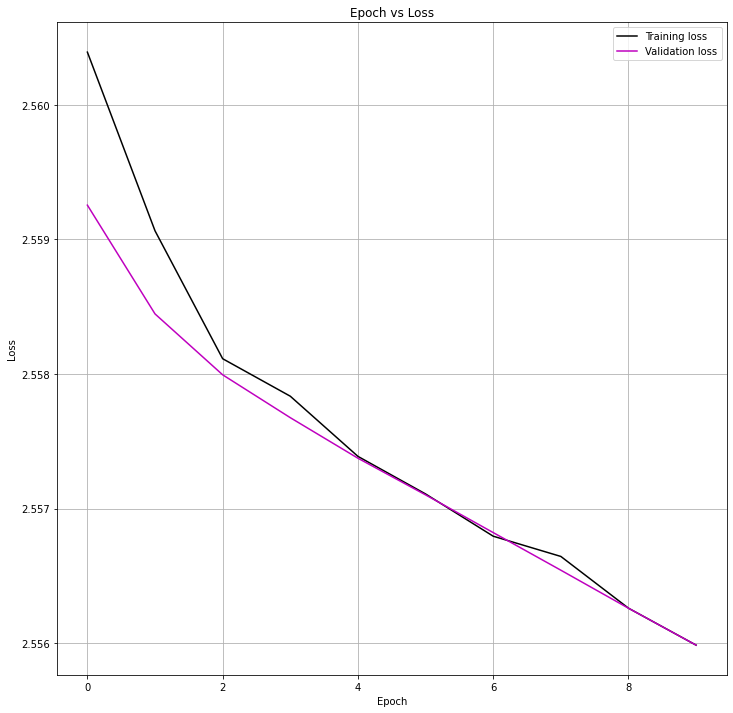

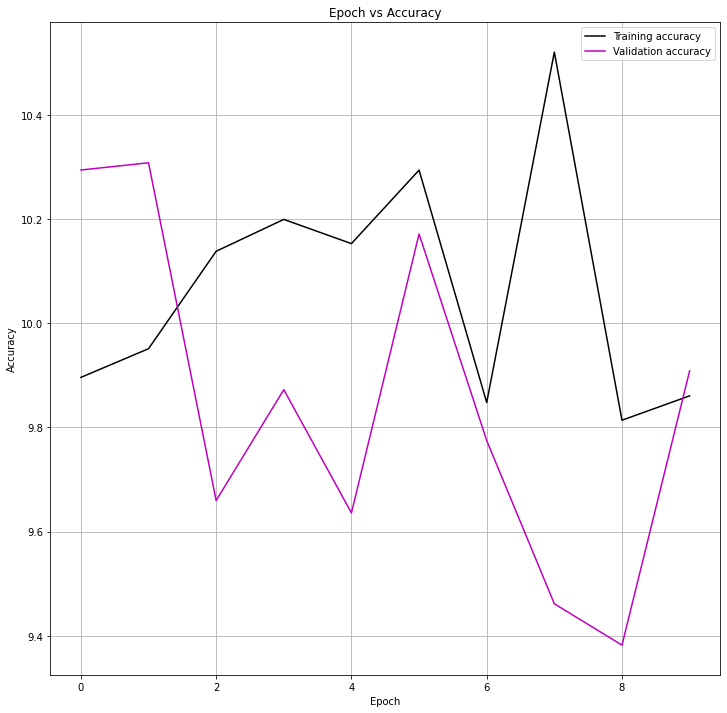



##### Evaluation module #####
Size of test data:  1250
Accuracy:  10.0
Confusion matrix: 
 Predicted      9    All
Actual                 
0           1000   1000
1           1000   1000
2           1000   1000
3           1000   1000
4           1000   1000
5           1000   1000
6           1000   1000
7           1000   1000
8           1000   1000
9           1000   1000
All        10000  10000


For 40 layers, the accuracy in test set is 10.0


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


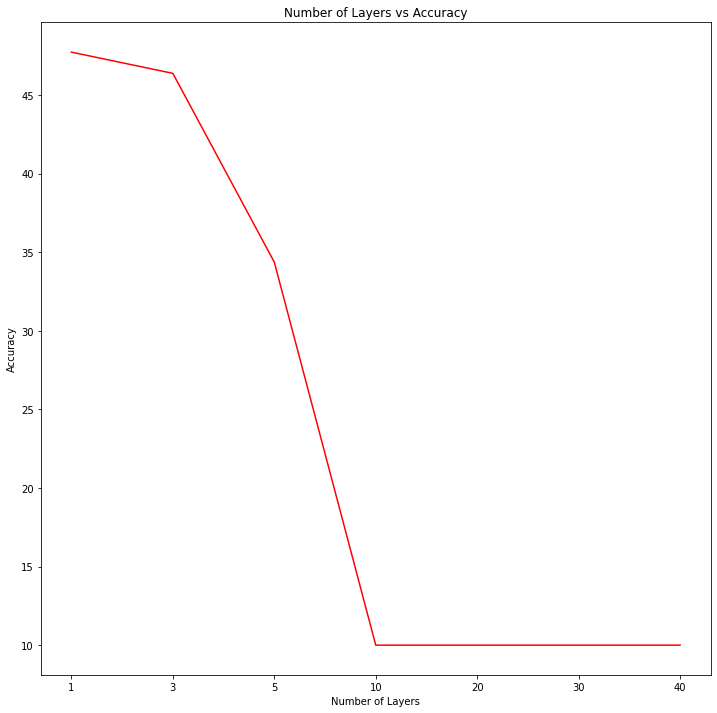

In [30]:
def layers_vs_accuracy():
    
    # Fix the different layers to run the model    
    layers_list = [1, 3, 5, 10, 20, 30, 40]
    accuracy_list = []
    
    for i in layers_list:    
        model, accuracy, writer = CIFAR10_classifier(experiment_name="Analyze-deeper-models",
                                             learning_rate=LEARNING_RATE,
                                             train_batch_size=TRAIN_BATCH_SIZE,
                                             patience=PATIENCE, 
                                             activation_function=ACTIVATION_FUNCTION, 
                                             num_epochs=NUM_EPOCHS, 
                                             hidden_units=HIDDEN_UNITS,
                                             num_layers=i, # Varying only the number of hidden layers
                                             optimizer_class=OPTIMIZER_CLASS, 
                                             weight_decay=WEIGHT_DECAY,
                                             regularization_level=REGULARIZATION_LEVEL,
                                             criterion_class=CRITERION_CLASS,
                                             early_stopping=EARLY_STOPPING,
                                             additional_scalar_identifier='_'+str(i)+'_layers',
                                             plot_gradients=False,
                                            )
        
        print("For {} layers, the accuracy in test set is {}".format(i, accuracy))
        accuracy_list.append(accuracy)
    
    fig_accuracy = plt.figure(figsize=(12,12))
    plt.plot(accuracy_list, color='red')
    plt.xlabel("Number of Layers")
    plt.ylabel("Accuracy")
    plt.title("Number of Layers vs Accuracy")
    plt.xticks(range(len(layers_list)), tuple(layers_list))
    plt.show()
    
    plot_to_tensorboard(writer, "Summary: Layers-Vs-Accuracy", fig_accuracy, 0)
    writer.close()

if LAYERS_VS_ACCURACY:
    layers_vs_accuracy()

### Findings:
1. On using more layers, the model generalization drops considerably.
2. However, the model shows considerably better performance upto certain threshold of layers.
3. From the gradient plots it is clear that larger models are not able to train the initial layers because of gradient vanishing at lower layers.



##### Statistics of the run #####
Learning rate:  0.01
Batch size for training:  100
Patience for early stopping:  3
Activation function:  RELU
Num epochs:  10
Num hidden units:  500
Num layers:  5
Optimizer class:  SGD
Regularizer level:  L2
Weight decay:  0
Criterion:  Manual Cross-Entropy
Number of train batches:  350
Number of validation batches:  150
Number of test batches:  1250
Model summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [100, 500]       1,536,500
              ReLU-2                 [100, 500]               0
           Dropout-3                 [100, 500]               0
            Linear-4                 [100, 100]          50,100
              ReLU-5                 [100, 100]               0
           Dropout-6                 [100, 100]               0
            Linear-7                 [100, 100]          10,100
              ReLU

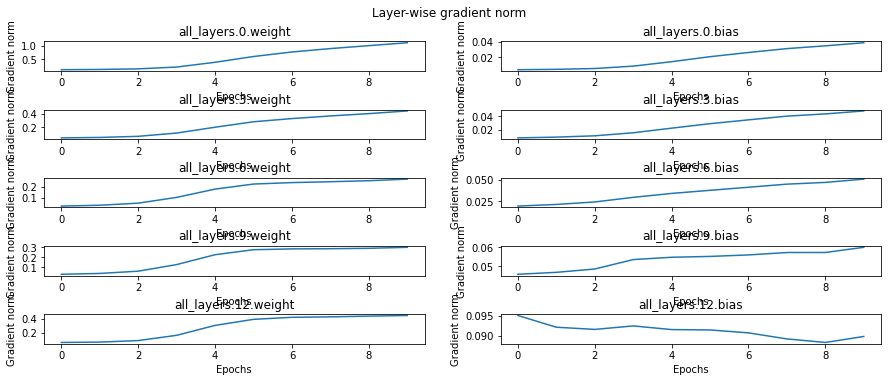

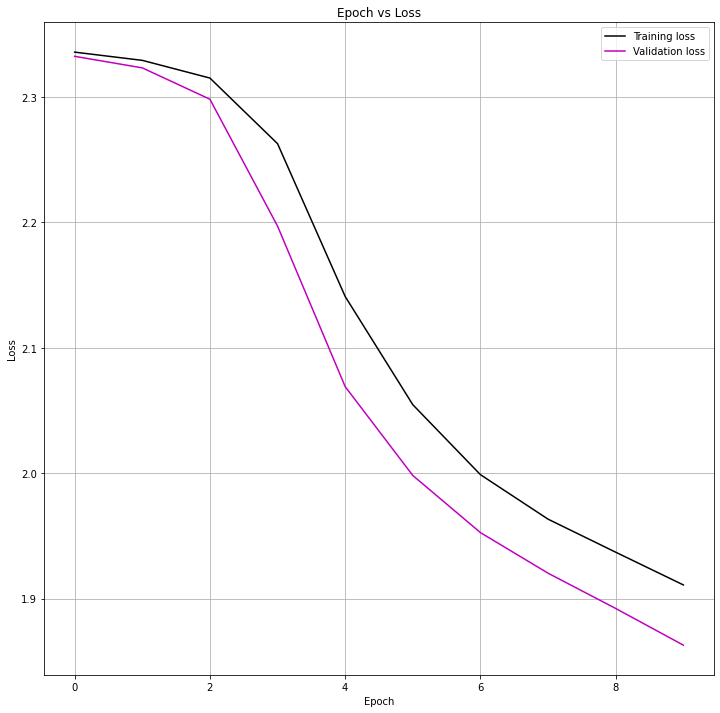

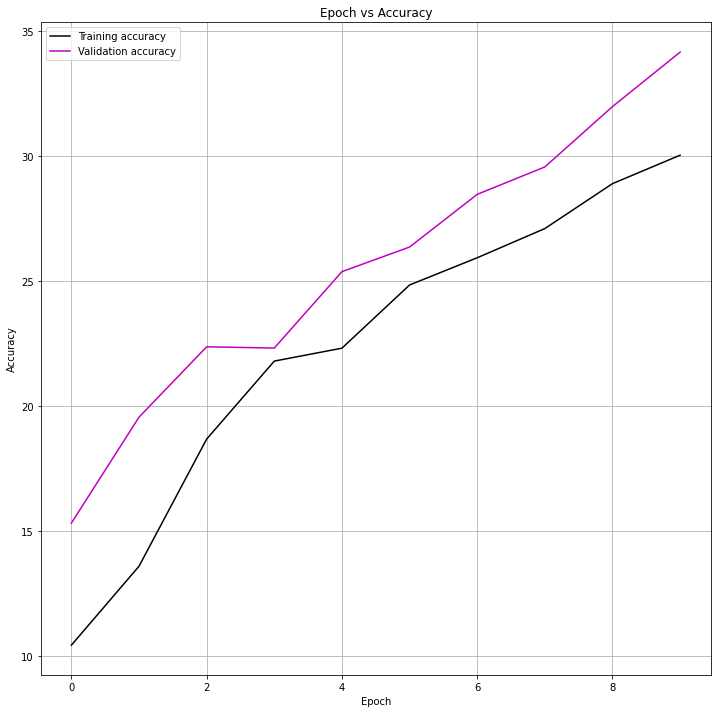



##### Evaluation module #####
Size of test data:  1250
Accuracy:  34.9
Confusion matrix: 
 Predicted     0    1    2    3    4     5     6     7     8     9    All
Actual                                                                  
0           482   41   40    7   16    29    33    45   250    57   1000
1            43  352    2   12    2    25    66    36   167   295   1000
2           145   35   63   11  182   128   278   104    28    26   1000
3            67   64   41   20   56   222   277   160    28    65   1000
4            59   32   19    8  238   116   360   103    37    28   1000
5            67   41   32   20  107   322   230   115    38    28   1000
6            11   38   25   12   90    79   592   111     7    35   1000
7            56   60   31    9  124   106   177   314    36    87   1000
8           178   65    4    5    5    41     7    23   576    96   1000
9            35  136    4    2    0    13    47    56   176   531   1000
All        1143  864  261  106 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


For SGD optimizer, the accuracy in test set is 34.9% and time taken for model convergence is 411.22841930389404 seconds


##### Statistics of the run #####
Learning rate:  0.01
Batch size for training:  100
Patience for early stopping:  3
Activation function:  RELU
Num epochs:  10
Num hidden units:  500
Num layers:  5
Optimizer class:  ADAM
Regularizer level:  L2
Weight decay:  0
Criterion:  Manual Cross-Entropy
Number of train batches:  350
Number of validation batches:  150
Number of test batches:  1250
Model summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [100, 500]       1,536,500
              ReLU-2                 [100, 500]               0
           Dropout-3                 [100, 500]               0
            Linear-4                 [100, 100]          50,100
              ReLU-5                 [100, 100]               0
           Dropout-6     

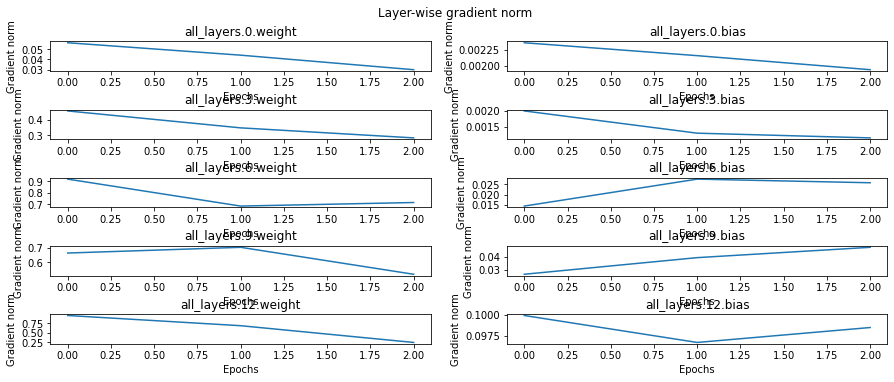

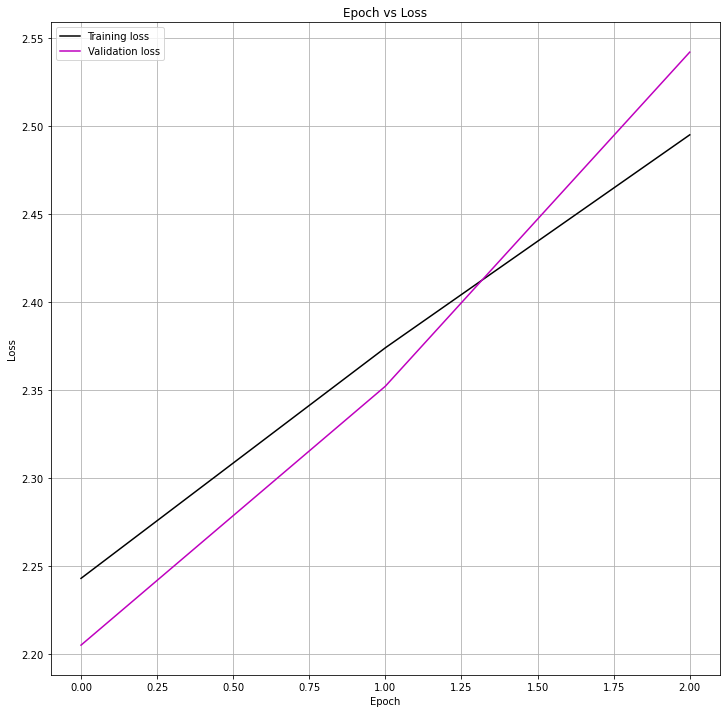

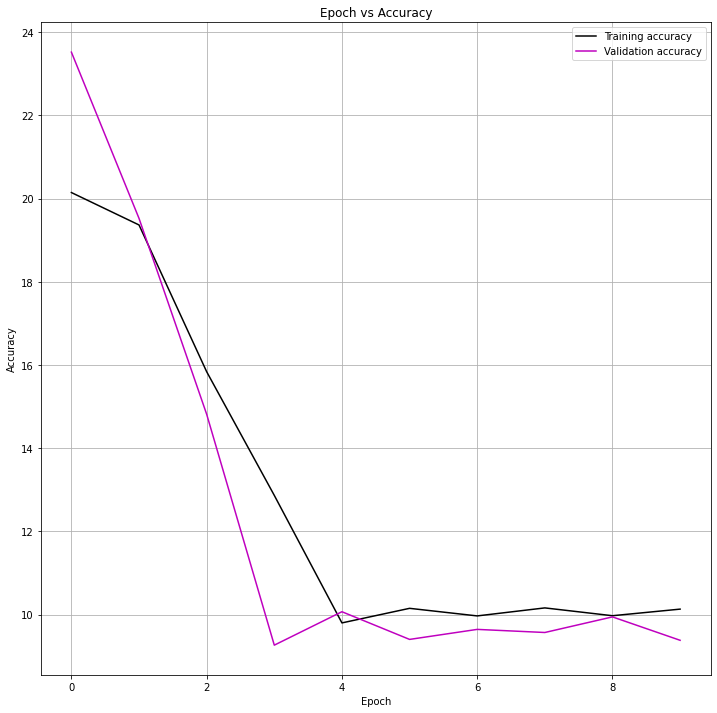



##### Evaluation module #####
Size of test data:  1250
Accuracy:  10.0
Confusion matrix: 
 Predicted      0    All
Actual                 
0           1000   1000
1           1000   1000
2           1000   1000
3           1000   1000
4           1000   1000
5           1000   1000
6           1000   1000
7           1000   1000
8           1000   1000
9           1000   1000
All        10000  10000




/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


For ADAM optimizer, the accuracy in test set is 10.0% and time taken for model convergence is 433.8695375919342 seconds


##### Statistics of the run #####
Learning rate:  0.01
Batch size for training:  100
Patience for early stopping:  3
Activation function:  RELU
Num epochs:  10
Num hidden units:  500
Num layers:  5
Optimizer class:  ADAGRAD
Regularizer level:  L2
Weight decay:  0
Criterion:  Manual Cross-Entropy
Number of train batches:  350
Number of validation batches:  150
Number of test batches:  1250
Model summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [100, 500]       1,536,500
              ReLU-2                 [100, 500]               0
           Dropout-3                 [100, 500]               0
            Linear-4                 [100, 100]          50,100
              ReLU-5                 [100, 100]               0
           Dropout-6  

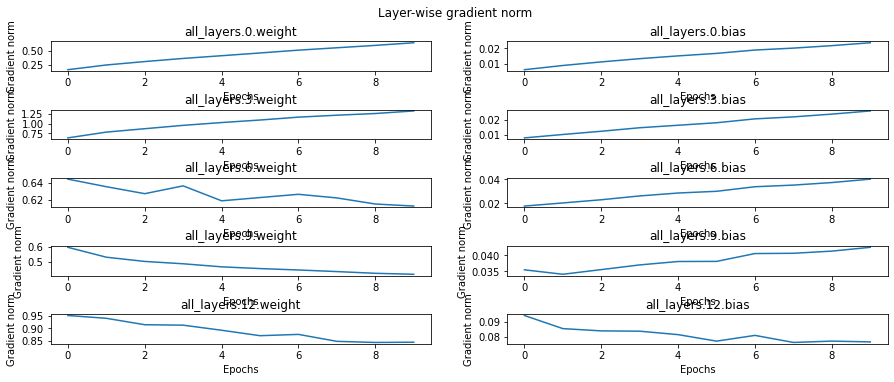

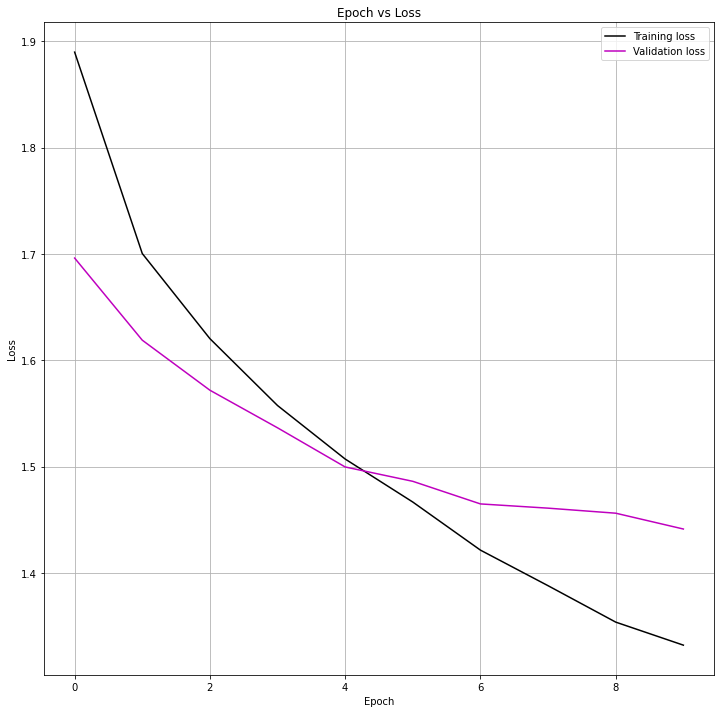

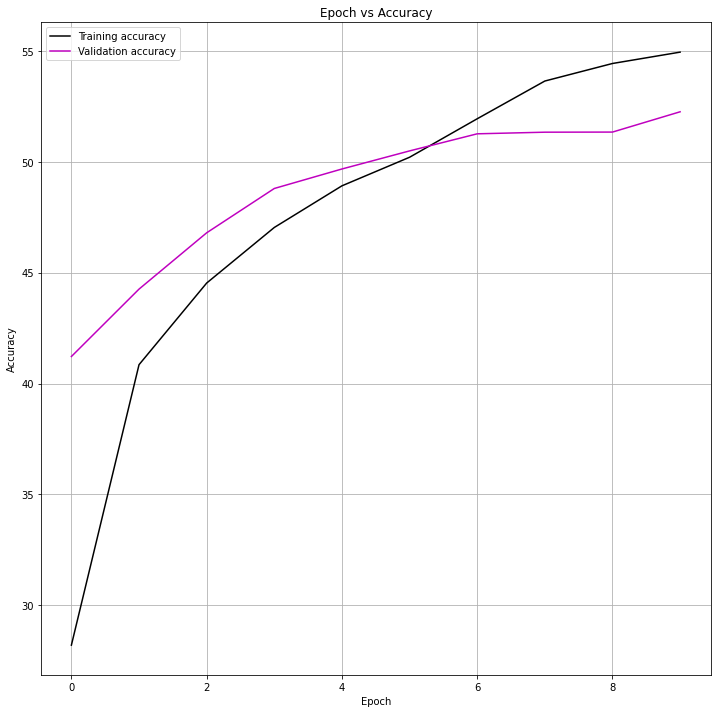



##### Evaluation module #####
Size of test data:  1250
Accuracy:  52.480000000000004
Confusion matrix: 
 Predicted     0    1    2    3    4    5     6     7     8     9    All
Actual                                                                 
0           610   31   62   15   31   11    24    23   141    52   1000
1            52  595   22   19   12   10    21    19    81   169   1000
2            95   16  388   80  144   84    93    65    17    18   1000
3            36   12   92  310   59  212   139    63    33    44   1000
4            64   17  137   56  421   50   113   102    22    18   1000
5            25    9  107  198   46  405    89    69    32    20   1000
6             9   17   70   62  139   45   606    20    15    17   1000
7            35    7   50   60   68   87    31   607    16    39   1000
8            91   59    8   20   13   26     3    10   706    64   1000
9            46  134   17   32   13   19    31    38    70   600   1000
All        1063  897  953  85

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


For ADAGRAD optimizer, the accuracy in test set is 52.480000000000004% and time taken for model convergence is 423.78666281700134 seconds


##### Statistics of the run #####
Learning rate:  0.01
Batch size for training:  100
Patience for early stopping:  3
Activation function:  RELU
Num epochs:  10
Num hidden units:  500
Num layers:  5
Optimizer class:  ADADELTA
Regularizer level:  L2
Weight decay:  0
Criterion:  Manual Cross-Entropy
Number of train batches:  350
Number of validation batches:  150
Number of test batches:  1250
Model summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [100, 500]       1,536,500
              ReLU-2                 [100, 500]               0
           Dropout-3                 [100, 500]               0
            Linear-4                 [100, 100]          50,100
              ReLU-5                 [100, 100]               0
   

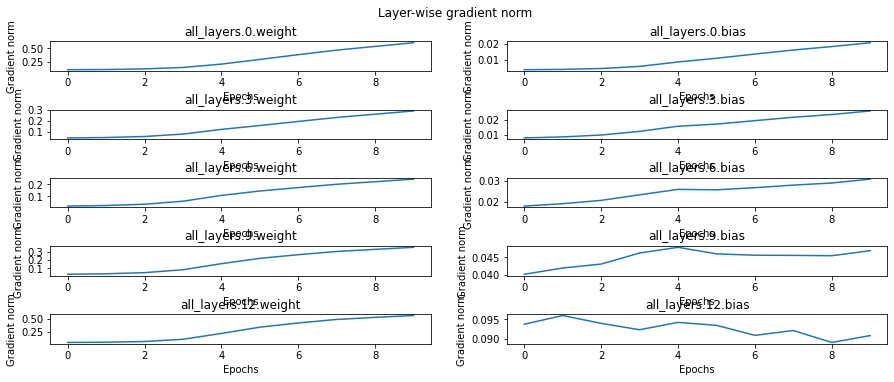

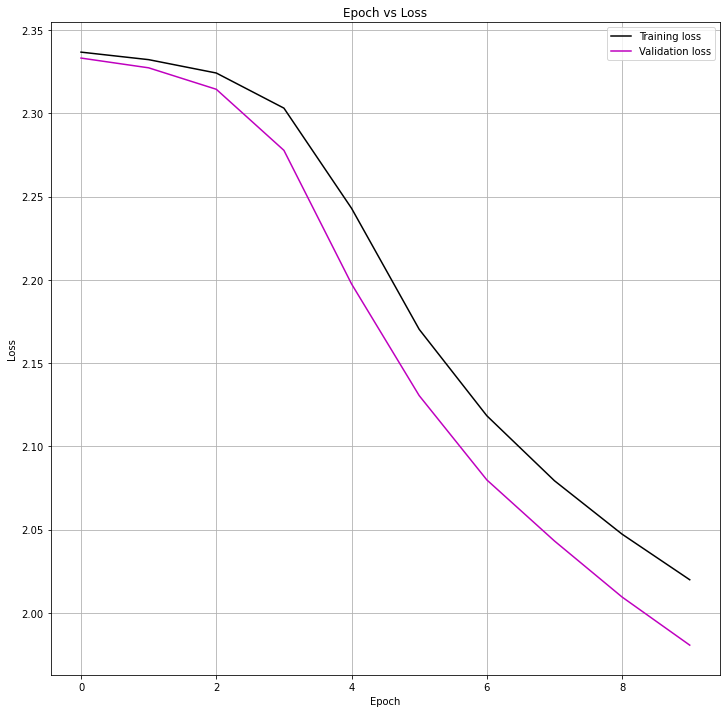

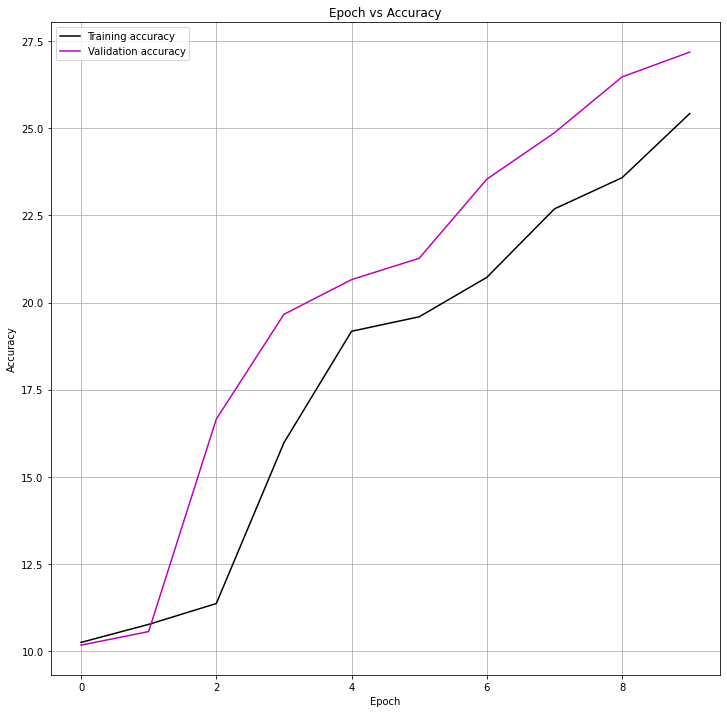



##### Evaluation module #####
Size of test data:  1250
Accuracy:  27.61
Confusion matrix: 
 Predicted     0    1   2    3    4    5     6    7     8     9    All
Actual                                                               
0           410   35   6   47   14    8    64   25   283   108   1000
1            50  152   6   18   14    8   125   32   187   408   1000
2           117   45  19   71   68   19   517   44    45    55   1000
3            62   56   7   73   57   65   473   91    22    94   1000
4            41   37   5   34   59   25   657   43    39    60   1000
5            66   43   6   81   49  107   511   61    31    45   1000
6            14   35   5   39   49   15   706   78     9    50   1000
7            58   41   3   53   65   35   373  167    34   171   1000
8           152   40   2   19    8   15    30   18   485   231   1000
9            41   64   2   10    7    6    69   55   163   583   1000
All        1011  548  61  445  390  303  3525  614  1298  1805  10

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


For ADADELTA optimizer, the accuracy in test set is 27.61% and time taken for model convergence is 436.42204904556274 seconds


##### Statistics of the run #####
Learning rate:  0.01
Batch size for training:  100
Patience for early stopping:  3
Activation function:  RELU
Num epochs:  10
Num hidden units:  500
Num layers:  5
Optimizer class:  RMSPROP
Regularizer level:  L2
Weight decay:  0
Criterion:  Manual Cross-Entropy
Number of train batches:  350
Number of validation batches:  150
Number of test batches:  1250
Model summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [100, 500]       1,536,500
              ReLU-2                 [100, 500]               0
           Dropout-3                 [100, 500]               0
            Linear-4                 [100, 100]          50,100
              ReLU-5                 [100, 100]               0
           Dropo

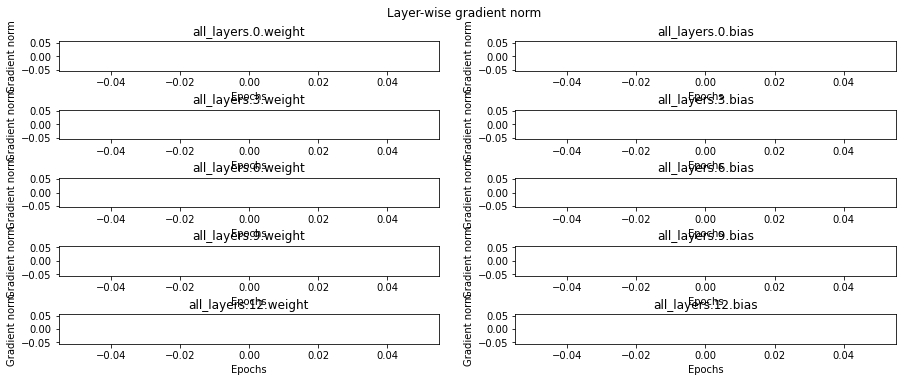

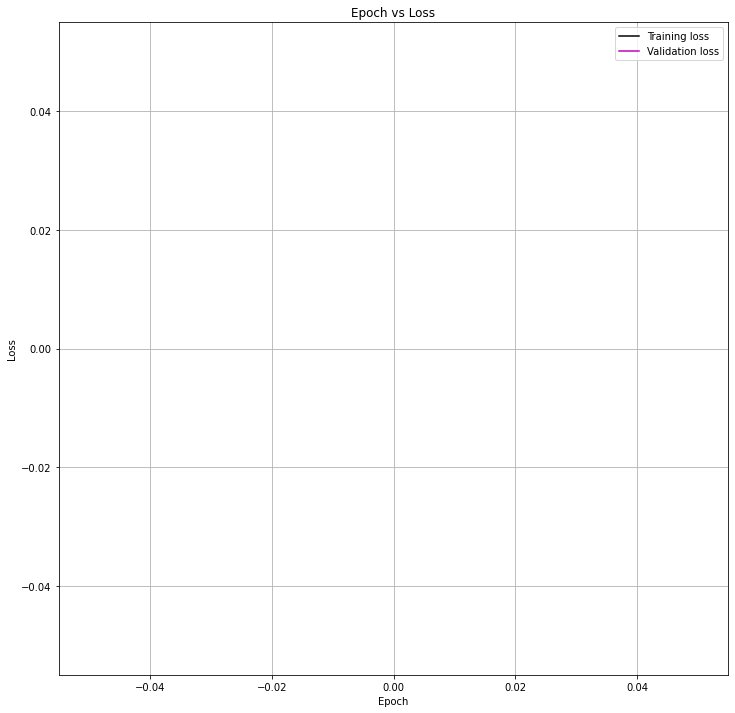

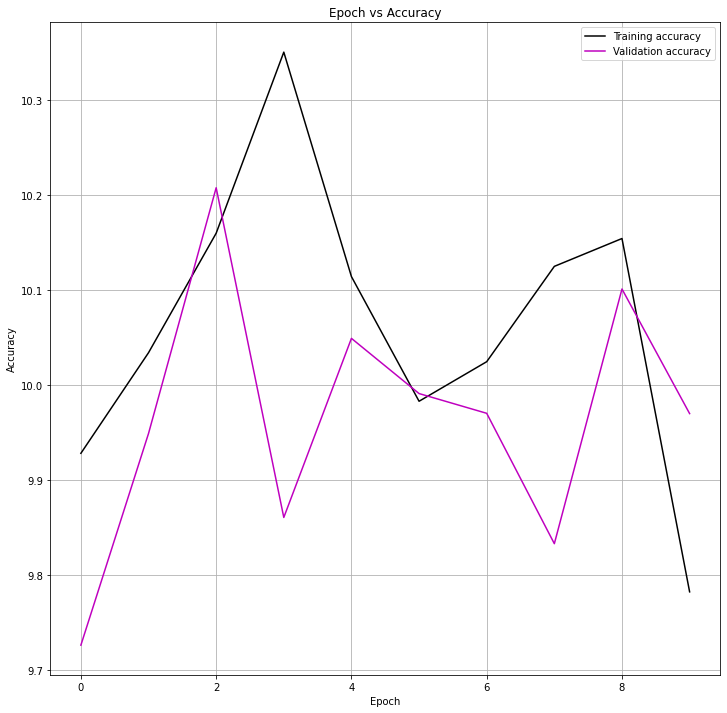



##### Evaluation module #####
Size of test data:  1250
Accuracy:  10.0
Confusion matrix: 
 Predicted      0    All
Actual                 
0           1000   1000
1           1000   1000
2           1000   1000
3           1000   1000
4           1000   1000
5           1000   1000
6           1000   1000
7           1000   1000
8           1000   1000
9           1000   1000
All        10000  10000




/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


For RMSPROP optimizer, the accuracy in test set is 10.0% and time taken for model convergence is 427.05307173728943 seconds


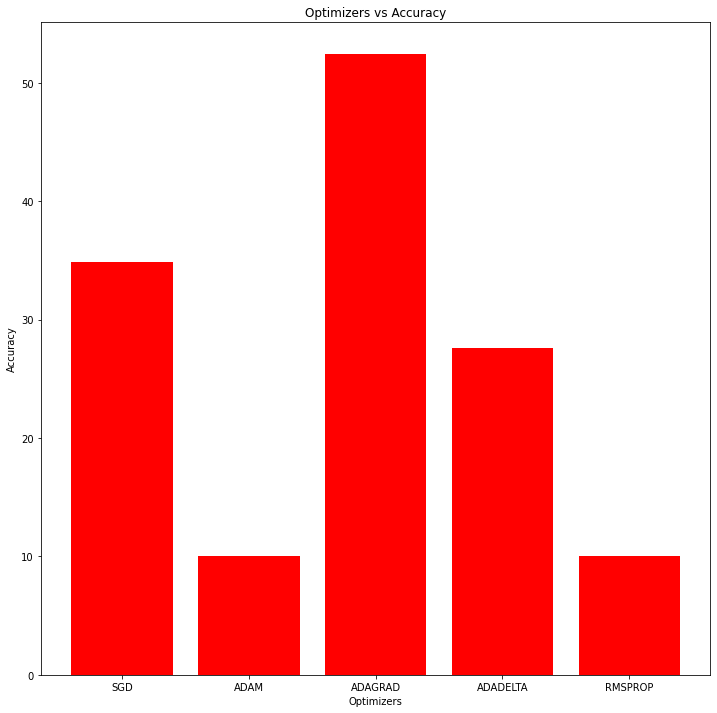

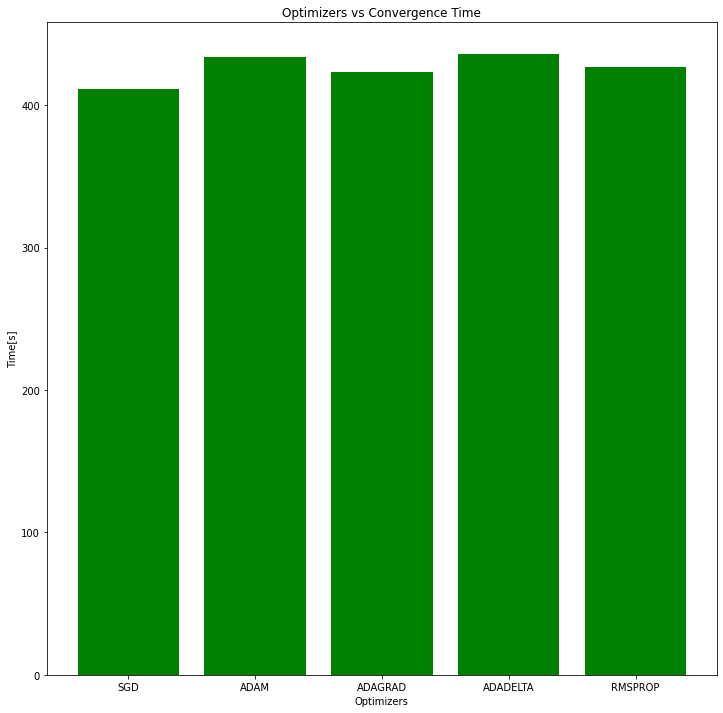

In [26]:
def analyze_optimizers():
    # Fix the different optimizers to run the model    
    optimizers_list = ["SGD", "ADAM", "ADAGRAD", "ADADELTA", "RMSPROP"]
    accuracy_list = []
    time_list = []
    
    for i in optimizers_list:
        start_time = time.time()
        model, accuracy, writer = CIFAR10_classifier(experiment_name="Analyze-optimizers",
                                             learning_rate=LEARNING_RATE,
                                             train_batch_size=TRAIN_BATCH_SIZE,
                                             patience=PATIENCE, 
                                             activation_function=ACTIVATION_FUNCTION, 
                                             num_epochs=NUM_EPOCHS, 
                                             hidden_units=HIDDEN_UNITS,
                                             num_layers=NUM_LAYERS, 
                                             optimizer_class=i, # Varying only the optimizer classes
                                             weight_decay=WEIGHT_DECAY,
                                             regularization_level=REGULARIZATION_LEVEL,
                                             criterion_class=CRITERION_CLASS,
                                             early_stopping=EARLY_STOPPING,
                                             additional_scalar_identifier='_'+i,
                                            )
        end_time = time.time()
        convergence_time = end_time - start_time
        print("For {} optimizer, the accuracy in test set is {}% and time taken for model convergence is {} seconds".format(i, accuracy, convergence_time))
        accuracy_list.append(accuracy)
        time_list.append(convergence_time)
    
    fig_accuracy = plt.figure(figsize=(12,12))
    plt.bar(range(len(accuracy_list)), accuracy_list, color='red')
    plt.xlabel("Optimizers")
    plt.ylabel("Accuracy")
    plt.title("Optimizers vs Accuracy")
    plt.xticks(range(len(optimizers_list)), tuple(optimizers_list))
    plt.show()
    fig_time = plt.figure(figsize=(12,12))
    plt.bar(range(len(accuracy_list)), time_list, color='green')
    plt.xlabel("Optimizers")
    plt.ylabel("Time[s]")
    plt.title("Optimizers vs Convergence Time")
    plt.xticks(range(len(optimizers_list)), tuple(optimizers_list))
    plt.show()
    plot_to_tensorboard(writer, "Summary: Optimizer-Vs-Accuracy[%]", fig_accuracy, 0)
    plot_to_tensorboard(writer, "Summary: Optimizer-Vs-Time[s]", fig_accuracy, 0)
    writer.close()
    
if ANALYZE_OPTIMIZERS:
    analyze_optimizers()

### Findings:
1. The training time is almost similar to all the optimizers because all the models are trained only for a fixed number of iterations. This is primarily due to the constrained time limit for performing many experiments.
2. The RMSprop provides NAN values. On performing various experiments with RMSprop with scenarios of changing the activations, loss functions, layers, the result is still nan value. This issue will be analyzed further and reported as soon as the reason is identified. Kindly let us know if there is any particular experiment to perform.
3. For the fixed epoch experiment, Adagrad shows better accuracy and relatively better convergence time. 



##### Statistics of the run #####
Learning rate:  0.01
Batch size for training:  100
Patience for early stopping:  3
Activation function:  RELU
Num epochs:  10
Num hidden units:  500
Num layers:  5
Optimizer class:  SGD
Regularizer level:  L2
Weight decay:  0
Criterion:  Manual Cross-Entropy
Number of train batches:  350
Number of validation batches:  150
Number of test batches:  1250
Model summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [100, 500]       1,536,500
              ReLU-2                 [100, 500]               0
           Dropout-3                 [100, 500]               0
            Linear-4                 [100, 100]          50,100
              ReLU-5                 [100, 100]               0
           Dropout-6                 [100, 100]               0
            Linear-7                 [100, 100]          10,100
              ReLU

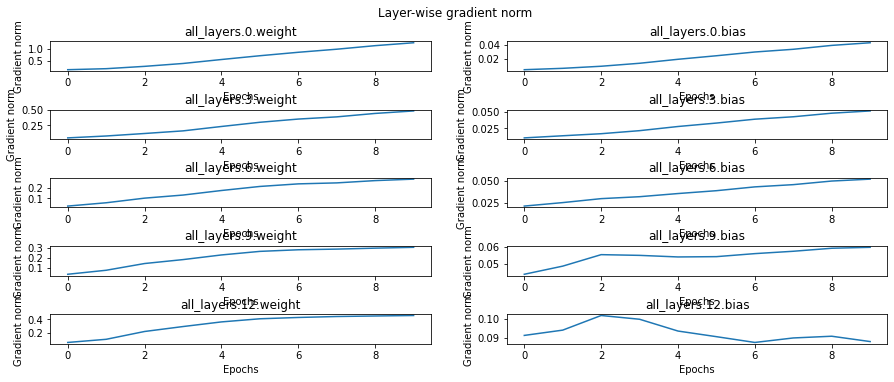

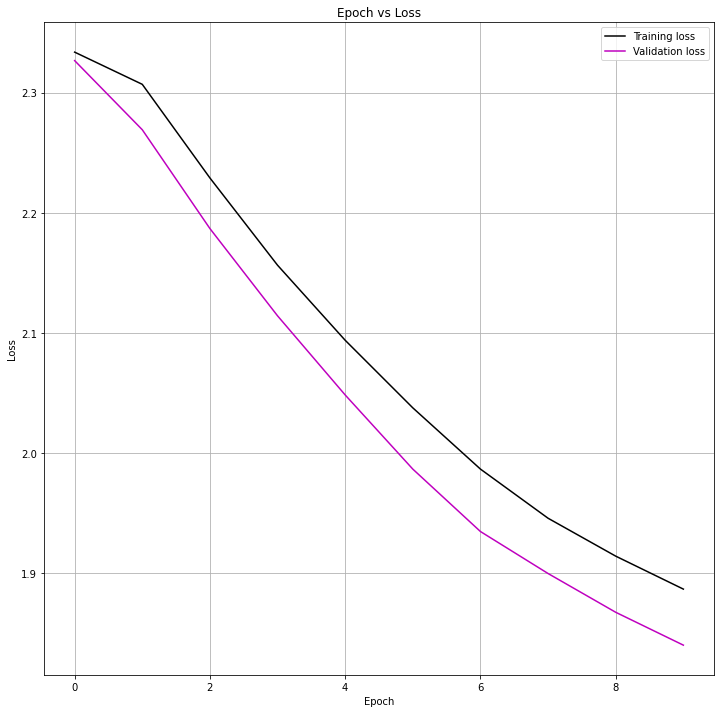

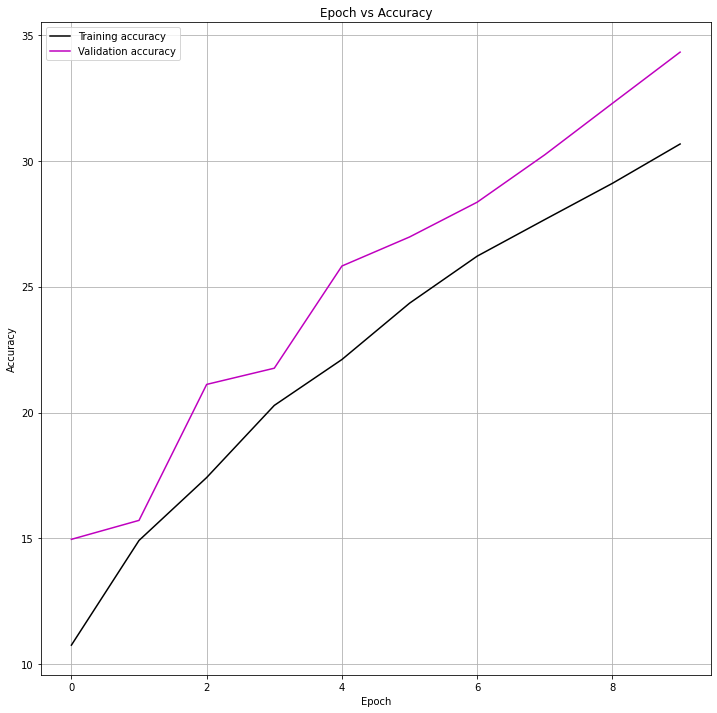



##### Evaluation module #####
Size of test data:  1250
Accuracy:  34.2
Confusion matrix: 
 Predicted     0     1    2   3    4    5     6     7     8     9    All
Actual                                                                 
0           463    56   63   0   10   15    36    56   240    61   1000
1            36   507    4   4    2   16    57    40   124   210   1000
2           137    34  126   8  128   42   351   125    25    24   1000
3            67    87   78   4   41   87   357   213    14    52   1000
4            58    44   69   5  146   35   458   134    23    28   1000
5            54    47   89   7   67  159   370   155    27    25   1000
6            16    44   45   0   52   40   637   143     2    21   1000
7            56    69   58   2   68   47   213   369    24    94   1000
8           193   121   12   1    4   13    14    31   527    84   1000
9            38   225    8   1    0    5    33    73   135   482   1000
All        1118  1234  552  32  518  459  2

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


For RELU layers, the accuracy in test set is 34.2


##### Statistics of the run #####
Learning rate:  0.01
Batch size for training:  100
Patience for early stopping:  3
Activation function:  SIGMOID
Num epochs:  10
Num hidden units:  500
Num layers:  5
Optimizer class:  SGD
Regularizer level:  L2
Weight decay:  0
Criterion:  Manual Cross-Entropy
Number of train batches:  350
Number of validation batches:  150
Number of test batches:  1250
Model summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [100, 500]       1,536,500
           Sigmoid-2                 [100, 500]               0
           Dropout-3                 [100, 500]               0
            Linear-4                 [100, 100]          50,100
           Sigmoid-5                 [100, 100]               0
           Dropout-6                 [100, 100]               0
            Linear-7         

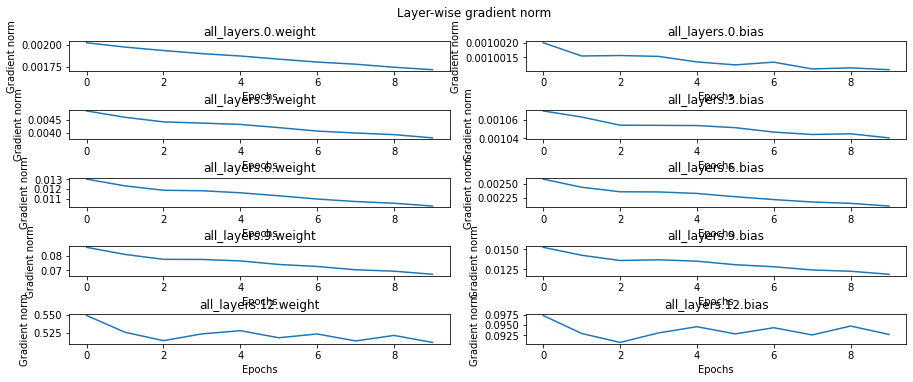

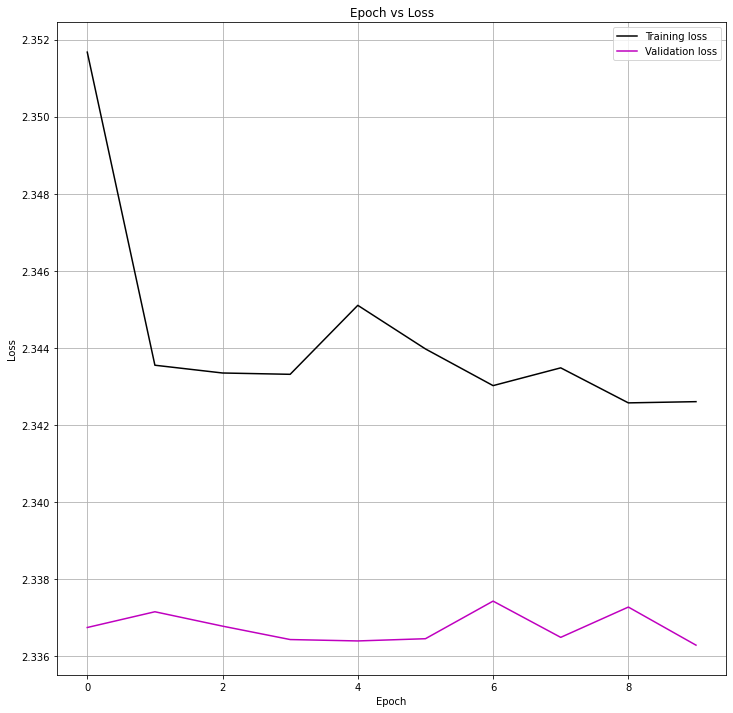

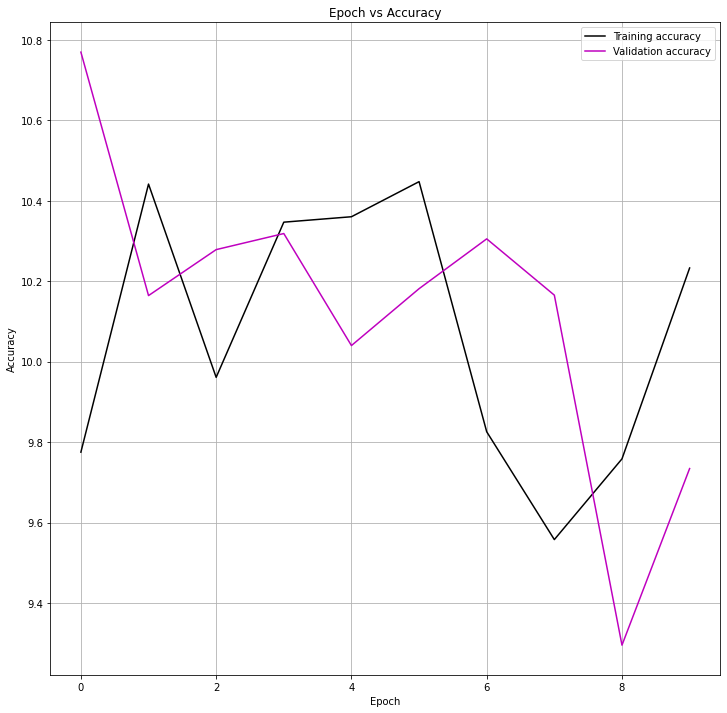



##### Evaluation module #####
Size of test data:  1250
Accuracy:  10.0
Confusion matrix: 
 Predicted      8    All
Actual                 
0           1000   1000
1           1000   1000
2           1000   1000
3           1000   1000
4           1000   1000
5           1000   1000
6           1000   1000
7           1000   1000
8           1000   1000
9           1000   1000
All        10000  10000




/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


For SIGMOID layers, the accuracy in test set is 10.0


##### Statistics of the run #####
Learning rate:  0.01
Batch size for training:  100
Patience for early stopping:  3
Activation function:  TANH
Num epochs:  10
Num hidden units:  500
Num layers:  5
Optimizer class:  SGD
Regularizer level:  L2
Weight decay:  0
Criterion:  Manual Cross-Entropy
Number of train batches:  350
Number of validation batches:  150
Number of test batches:  1250
Model summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [100, 500]       1,536,500
              Tanh-2                 [100, 500]               0
           Dropout-3                 [100, 500]               0
            Linear-4                 [100, 100]          50,100
              Tanh-5                 [100, 100]               0
           Dropout-6                 [100, 100]               0
            Linear-7         

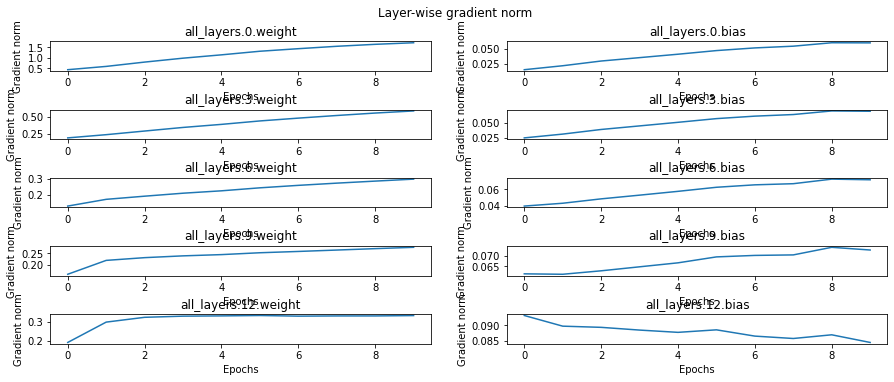

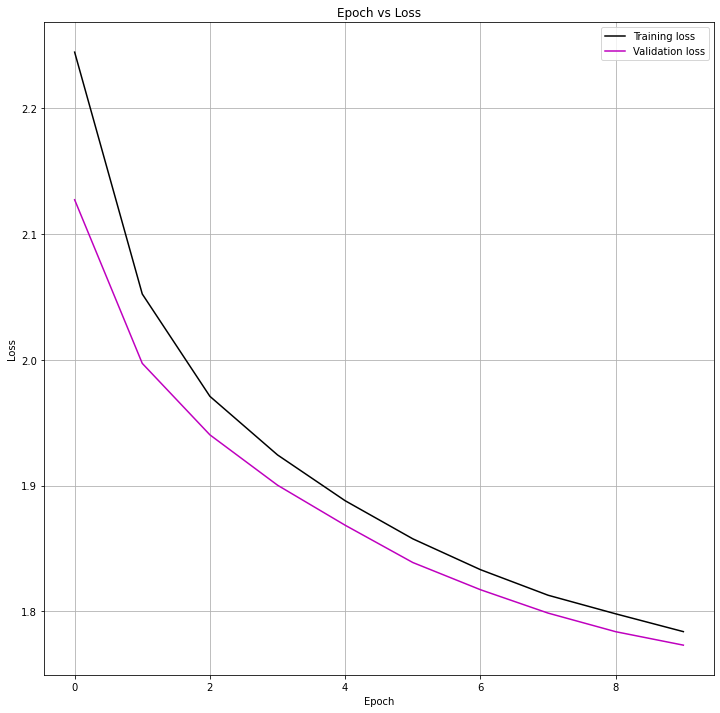

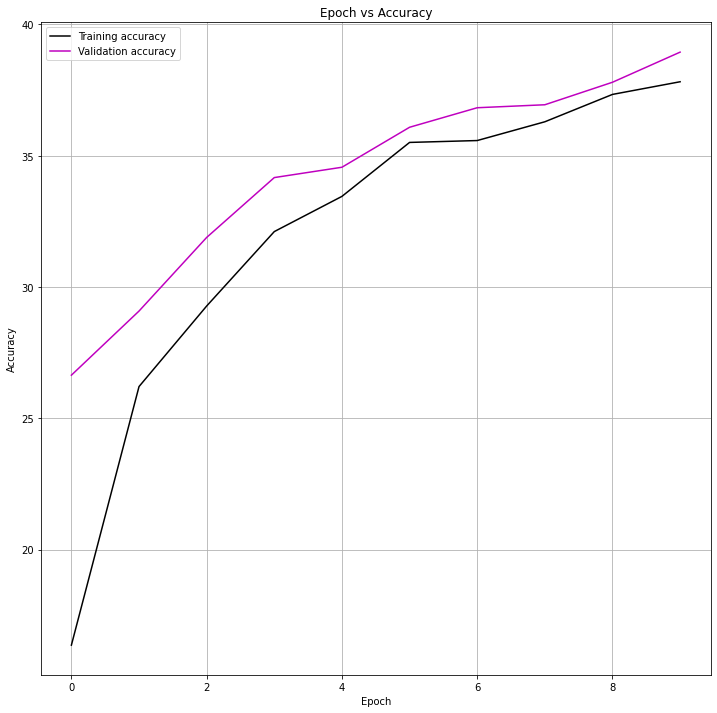



##### Evaluation module #####
Size of test data:  1250
Accuracy:  39.01
Confusion matrix: 
 Predicted     0    1    2    3    4    5     6     7     8     9    All
Actual                                                                 
0           471   41   33   21   12   29    36    65   214    78   1000
1            50  432   18   34    8   29    63    40    98   228   1000
2           119   46  177   53  122   80   241    98    42    22   1000
3            32   58   84  176   33  213   223    70    43    68   1000
4            61   31  121   32  234   69   281   118    27    26   1000
5            43   34   89  110   58  334   156    93    53    30   1000
6             9   32   89   68   55   69   604    34    12    28   1000
7            52   38   41   47  112   62    90   419    35   104   1000
8           160   74   16   19    3   45    16    22   526   119   1000
9            60  135   15   22    6   14    63    63    94   528   1000
All        1057  921  683  582  643  944  

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


For TANH layers, the accuracy in test set is 39.01


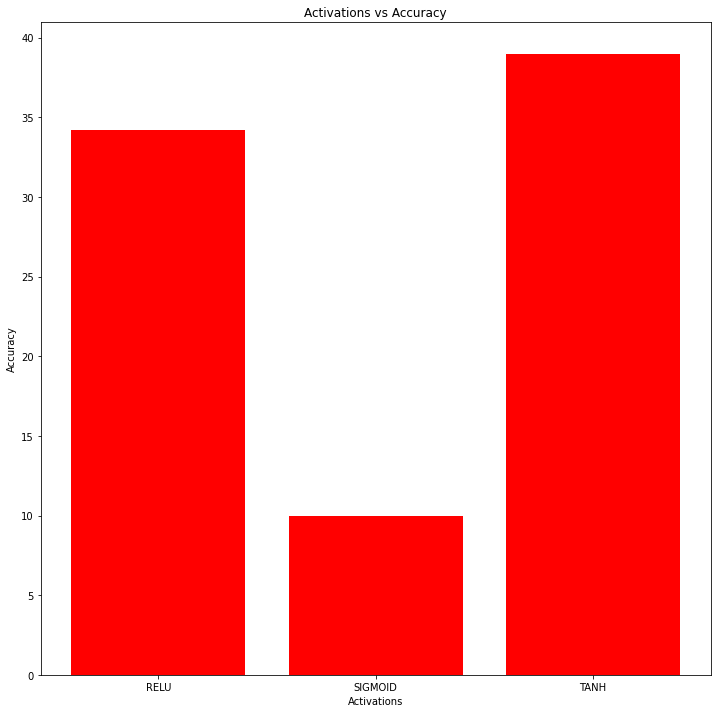

In [27]:
def analyze_activations():
    
    # Fix the different activations to run the model    
    activations_list = ["RELU", "SIGMOID", "TANH"]
    accuracy_list = []
    
    for i in activations_list:    
        model, accuracy, writer = CIFAR10_classifier(experiment_name="Analyze-activations",
                                             learning_rate=LEARNING_RATE,
                                             train_batch_size=TRAIN_BATCH_SIZE,
                                             patience=PATIENCE, 
                                             activation_function=i, # Varying only the activations
                                             num_epochs=NUM_EPOCHS, 
                                             hidden_units=HIDDEN_UNITS,
                                             num_layers=NUM_LAYERS, 
                                             optimizer_class=OPTIMIZER_CLASS, 
                                             weight_decay=WEIGHT_DECAY,
                                             regularization_level=REGULARIZATION_LEVEL,
                                             criterion_class=CRITERION_CLASS,
                                             early_stopping=EARLY_STOPPING,
                                             additional_scalar_identifier='_'+i,
                                            )
        
        print("For {} layers, the accuracy in test set is {}".format(i, accuracy))
        accuracy_list.append(accuracy)
     
    fig_accuracy = plt.figure(figsize=(12, 12))
    plt.bar(range(len(accuracy_list)), accuracy_list, color='red')
    plt.xlabel("Activations")
    plt.ylabel("Accuracy")
    plt.title("Activations vs Accuracy")
    plt.xticks(range(len(activations_list)), tuple(activations_list))
    plt.show()
    plot_to_tensorboard(writer, "Summary: Activations-Vs-Accuracy", fig_accuracy, 0)
    writer.close()

if ANALYZE_ACTIVATIONS:
    analyze_activations()

### Findings:
1. For this fixed number of epochs experiment, Tanh provides best accuracy and sigmoid provides the least accuracy.
2. The learning is smooth in tanh and ReLU. However, in sigmoid the learning curve is not smooth and erratic.



##### Statistics of the run #####
Learning rate:  0.01
Batch size for training:  100
Patience for early stopping:  3
Activation function:  RELU
Num epochs:  10
Num hidden units:  500
Num layers:  5
Optimizer class:  SGD
Regularizer level:  L1
Weight decay:  0
Criterion:  Manual Cross-Entropy
Number of train batches:  350
Number of validation batches:  150
Number of test batches:  1250
Model summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [100, 500]       1,536,500
              ReLU-2                 [100, 500]               0
           Dropout-3                 [100, 500]               0
            Linear-4                 [100, 100]          50,100
              ReLU-5                 [100, 100]               0
           Dropout-6                 [100, 100]               0
            Linear-7                 [100, 100]          10,100
              ReLU

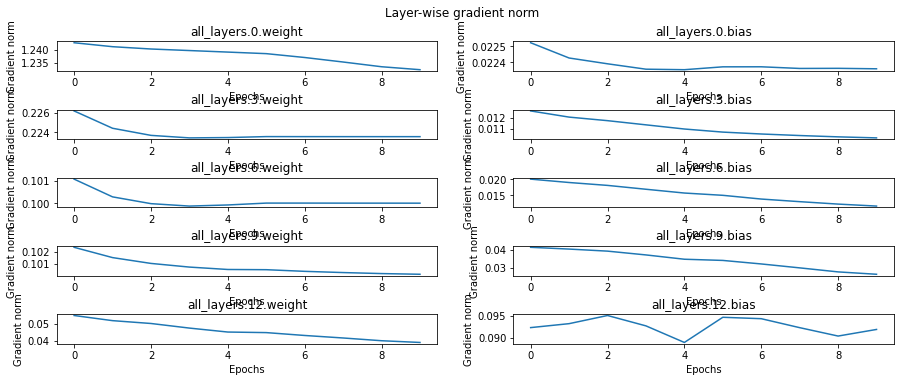

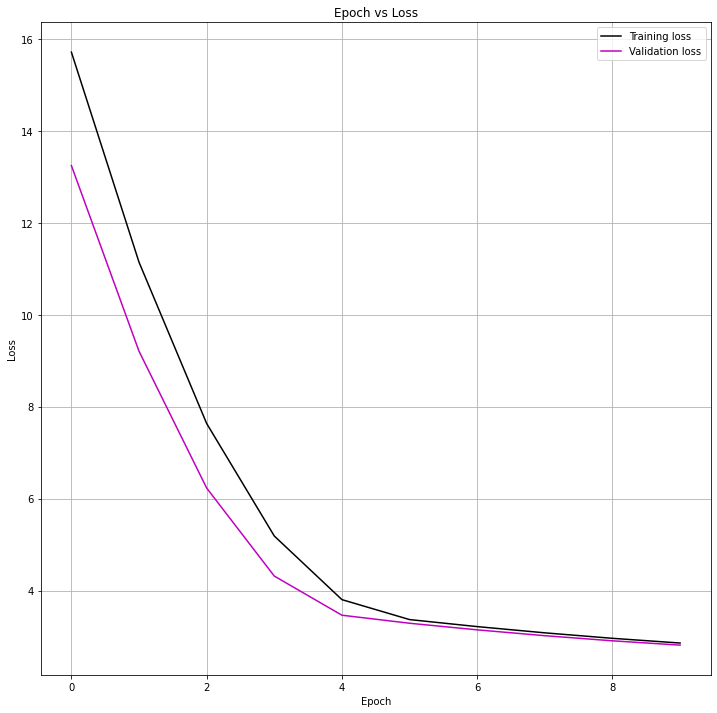

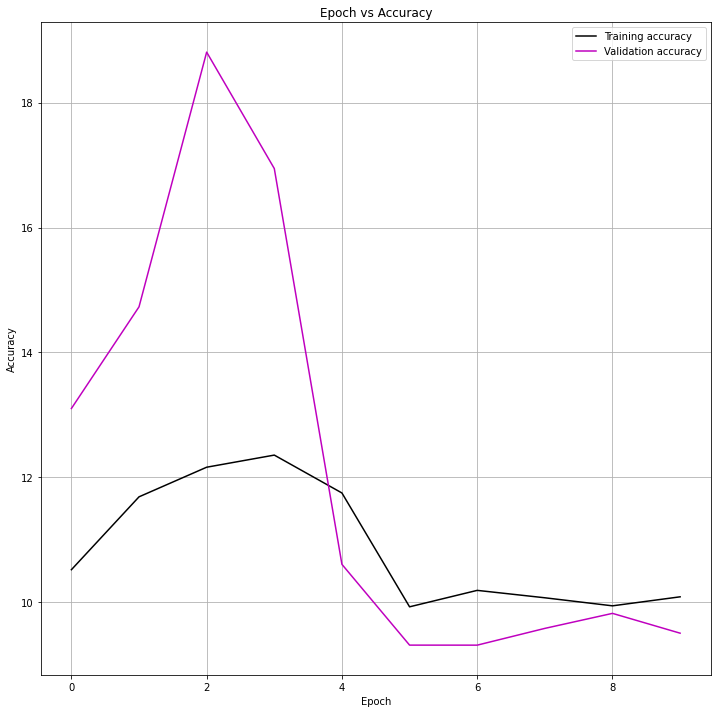



##### Evaluation module #####
Size of test data:  1250
Accuracy:  10.0
Confusion matrix: 
 Predicted      9    All
Actual                 
0           1000   1000
1           1000   1000
2           1000   1000
3           1000   1000
4           1000   1000
5           1000   1000
6           1000   1000
7           1000   1000
8           1000   1000
9           1000   1000
All        10000  10000




/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


In [28]:
model, accuracy, writer = CIFAR10_classifier(experiment_name="Final-run",
                                             learning_rate=LEARNING_RATE, 
                                             train_batch_size=TRAIN_BATCH_SIZE, 
                                             patience=PATIENCE, 
                                             activation_function=ACTIVATION_FUNCTION, 
                                             num_epochs=NUM_EPOCHS, 
                                             hidden_units=HIDDEN_UNITS,
                                             num_layers=NUM_LAYERS,
                                             optimizer_class=OPTIMIZER_CLASS, 
                                             weight_decay=WEIGHT_DECAY,
                                             regularization_level="L1",
                                             criterion_class=CRITERION_CLASS,
                                             early_stopping=True,
                                             close_writer=True,
                                             additional_scalar_identifier="_Final_run"
                                            )



##### Statistics of the run #####
Learning rate:  0.01
Batch size for training:  100
Patience for early stopping:  3
Activation function:  RELU
Num epochs:  10
Num hidden units:  500
Num layers:  5
Optimizer class:  SGD
Regularizer level:  L2
Weight decay:  0
Criterion:  Manual Cross-Entropy
Number of train batches:  350
Number of validation batches:  150
Number of test batches:  1250
Model summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [100, 500]       1,536,500
              ReLU-2                 [100, 500]               0
           Dropout-3                 [100, 500]               0
            Linear-4                 [100, 100]          50,100
              ReLU-5                 [100, 100]               0
           Dropout-6                 [100, 100]               0
            Linear-7                 [100, 100]          10,100
              ReLU

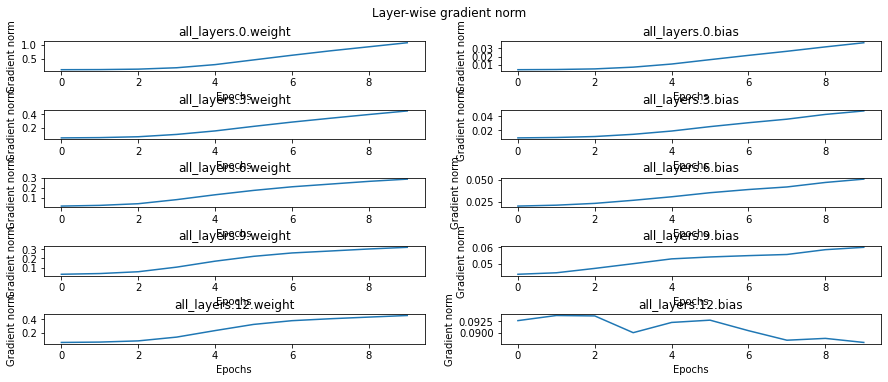

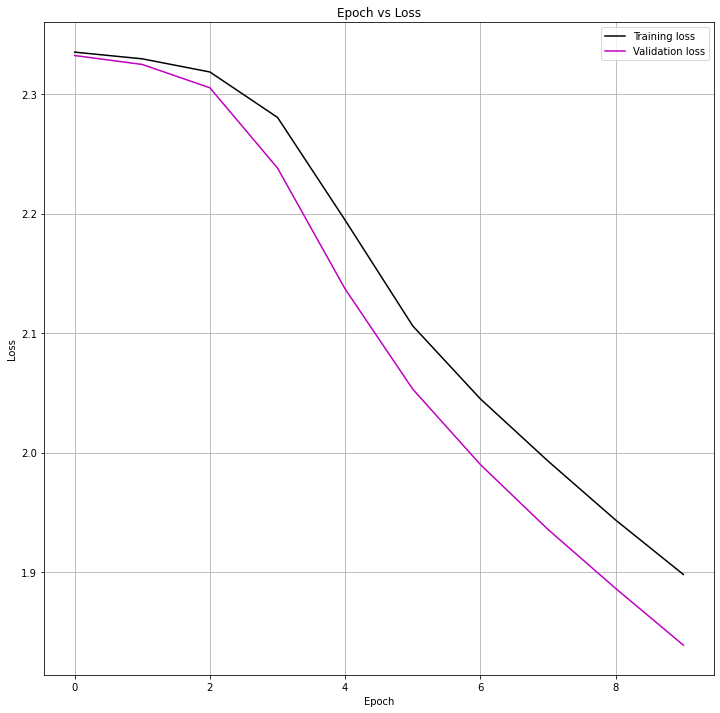

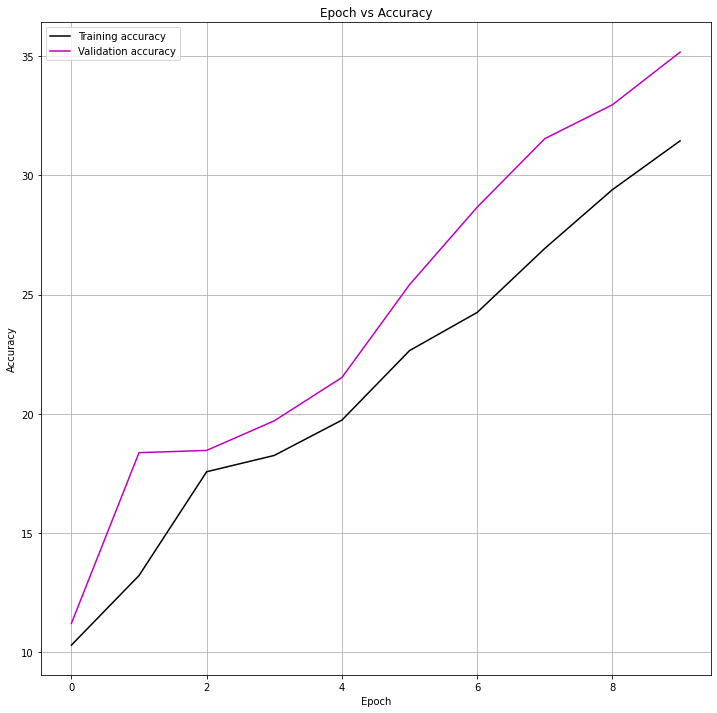



##### Evaluation module #####
Size of test data:  1250
Accuracy:  34.82
Confusion matrix: 
 Predicted    0     1    2   3    4     5     6     7     8     9    All
Actual                                                                 
0          430    48   57   3   15    21    36    55   272    63   1000
1           31   427    7   6    4    30    66    27   151   251   1000
2          131    37  117   6  105   128   320    94    30    32   1000
3           48    66   52  17   37   316   223   151    24    66   1000
4           52    38   66   7  139   124   408    98    33    35   1000
5           39    38   57  16   59   426   197    96    40    32   1000
6            8    46   41  11   63   110   576    96     4    45   1000
7           51    57   49   6   78   159   150   312    35   103   1000
8          166    79    5   6    3    54     8    21   536   122   1000
9           22   168    6   7    1    17    50    53   174   502   1000
All        978  1004  457  85  504  1385  

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


In [29]:
model, accuracy, writer = CIFAR10_classifier(experiment_name="Final-run",
                                             learning_rate=LEARNING_RATE, 
                                             train_batch_size=TRAIN_BATCH_SIZE, 
                                             patience=PATIENCE, 
                                             activation_function=ACTIVATION_FUNCTION, 
                                             num_epochs=NUM_EPOCHS, 
                                             hidden_units=HIDDEN_UNITS,
                                             num_layers=NUM_LAYERS,
                                             optimizer_class=OPTIMIZER_CLASS, 
                                             weight_decay=WEIGHT_DECAY,
                                             regularization_level=REGULARIZATION_LEVEL,
                                             criterion_class=CRITERION_CLASS,
                                             early_stopping=True,
                                             close_writer=True,
                                             additional_scalar_identifier="_Final_run"
                                            )